<a href="https://colab.research.google.com/github/iankim20/pyupbit_kyt/blob/main/upbit_obv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os, sys

nb_path = '/content/notebooks@'
os.symlink('/content/drive/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

# !pip install --target=$nb_path pyupbit
# !pip install --target=$nb_path trendet


In [ ]:
%ls "/content"

 drive/  'notebooks@'@   sample_data/


In [ ]:
import pyupbit
import pandas as pd
import numpy as np
import os
import openpyxl
import datetime
import time
import random
import requests
from bs4 import BeautifulSoup
import matplotlib
import matplotlib.pyplot as plt
import json

from sklearn.linear_model import LinearRegression

In [ ]:
# pip install pyti

In [ ]:
%cd "/content/drive/My Drive/autotrade"

/content/drive/My Drive/autotrade


In [ ]:
def get_recent_tick5(coin):
  req    = requests.get(f'https://crix-api-endpoint.upbit.com/v1/crix/candles/ticks/1?code=CRIX.UPBIT.{coin}&count=5')
  data   = req.json()
  result = []

  for i, candle in enumerate(data):
    result.append({
        'Time'                 : data[i]["candleDateTimeKst"], 
        'OpeningPrice'         : data[i]["openingPrice"],
        'HighPrice'            : data[i]["highPrice"],
        'LowPrice'             : data[i]["lowPrice"],
        'TradePrice'           : data[i]["tradePrice"],
        'CandleAccTradeVolume' : data[i]["candleAccTradeVolume"],
        "candleAccTradePrice"  : data[i]["candleAccTradePrice"]
    })
  return result


In [ ]:
print([x['HighPrice'] for x in get_recent_tick5("KRW-XRP")])
print([x['LowPrice'] for x in get_recent_tick5("KRW-XRP")])


[1130.0, 1130.0, 1125.0, 1130.0, 1125.0]
[1130.0, 1130.0, 1125.0, 1130.0, 1125.0]


In [ ]:
!rm /etc/localtime
!ln -s /usr/share/zoneinfo/Asia/Seoul /etc/localtime
now = !date

['Mon Sep 27 23:41:54 KST 2021']

In [ ]:
!sudo ln -sf /usr/share/zoneinfo/Asia/Seoul /etc/localtime

In [ ]:
def find(lst, key, value):
    index_lst = []
    for i, dic in enumerate(lst):
        if dic[key] == value:
            index_lst.append(i)
    return np.array(index_lst)

In [ ]:
get_data("KRW-BTC", interval="minute1", count=(40+1)*5,to="20210927103400")

In [ ]:
coin_down_dict_min5 = {"coin": "coin", "sum": 123, 'last_date_5min_down':12345, "time_len_5min_down": 51, 'buy_price': 123123} 


In [ ]:
def get_data(ticker, interval, count=200, to=None):
    # if (interval == "day"):
    # param = count/200

    counter = count
    index=0


    if counter >= 200: 
        while counter > 0:
            check = 1
            if counter > 200: 
                while check > 0:
                    try:
                        df_tail = pyupbit.get_ohlcv(ticker, interval=interval, count=200, to=to).drop_duplicates()
                        check-=1
                    except Exception as e:
                        print (e)
                        print ('Restarting upbit.getohlcv inside of get_data 1!')
                        time.sleep(1)
                        continue
            elif counter <= 200:
                while check > 0:
                    try:
                        df_tail = pyupbit.get_ohlcv(ticker, interval=interval, count=counter, to=to).drop_duplicates()
                        check-=1
                    except Exception as e:
                        print (e)
                        print ('Restarting upbit.getohlcv inside of get_data 2!')
                        time.sleep(1)
                        continue            

            if interval =='day':
                # next_date = df_sub.index[-1]-datetime.timedelta(days=1*200)
                next_date = df_tail.index[0]

            elif 'minute' in interval:
                # unit = int(interval.replace('minute', ''))
                # next_date = df_sub.index[-1]-datetime.timedelta(minutes = unit*200)
                next_date = df_tail.index[0]

            # date_format = datetime.datetime.fromisoformat(str(next_date))
            # if date_format.hour >= 9:
            next_date -= datetime.timedelta(hours=9)
            # elif date_format.hour < 9:
                # next_date -= datetime.timedelta (hours=9)
            date_string = next_date.strftime("%Y%m%d%H%M%S")
            
            if index > 0:
                df_tail = pd.concat([df_tail, df_sub]).drop_duplicates()

            df_sub = df_tail.copy()

            to = date_string
            counter -= 200
            index +=1

    elif counter < 200:
        check = 1
        while check > 0:
            try:
                df_tail = pyupbit.get_ohlcv(ticker, interval=interval, count=counter, to=to).drop_duplicates()
                check-=1
            except Exception as e:
                print (e)
                print ('Restarting upbit.getohlcv inside of get_data 3!')
                time.sleep(1)
                continue        

    # df_final = df_tail.copy()
    # print("length is ", len(df_final))


    return df_tail

In [ ]:
def draw_frame (data, k, fee):
  df=data.copy()
  # 변동폭 * k 계산, (고가 - 저가) * k값
  
  
  df['range_k'] = (df['high'] - df['low']) * k

  # target(매수가), range 컬럼을 한칸씩 밑으로 내림(.shift(1))
  df['target'] = df['open'] + df['range_k'].shift(1)

  # ror(수익률), np.where(조건문, 참일때 값, 거짓일때 값), 사고팔 때 1-fee/100만큼 곱해야 하니까 두번 곱한다.
  df['ror'] = np.where(df['high'] > df['target'],
                      (df['close'] / df['target'])*(1-fee/100)*(1-fee/100),
                       1)

  # 누적 곱 계산(cumprod) => 누적 수익률
  df['hpr'] = df['ror'].cumprod()

  # Draw Down 계산 (누적 최대 값과 현재 hpr 차이 / 누적 최대값 * 100)
  df['dd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100

  #MDD 계산
  print("MDD(%): ", df['dd'].max())
  print("HPR(%): ", df['hpr'][-1])
  return df


In [ ]:
def draw_frame_ma_per (data, k, per, fee, ma):
  df=data.copy()

  df['ma5'] = df['close'].rolling(window=5).mean().shift(1)
  # 변동폭 * k 계산, (고가 - 저가) * k값  
  df['range_k'] = (df['high'] - df['low']) * k

  # target(매수가), range 컬럼을 한칸씩 밑으로 내림(.shift(1))
  df['target'] = df['open'] + df['range_k'].shift(1)
  df['close_to_target'] = (df['close']/df['target']-1)*100
  df['close_to_open'] = (df['close']/df['open']-1)*100


  if ma:
    df['bull'] = df['open'] > df['ma5']
    # ror(수익률), np.where(조건문, 참일때 값, 거짓일때 값), 사고팔 때 1-fee/100만큼 곱해야 하니까 두번 곱한다.
    df['ror'] = np.where((df['high'] > df['target']) & (df['high']>= (1+per/100)*df['target']) & df['bull'],
                        (1+per/100)*(1-fee/100)*(1-fee/100),
                        np.where((df['high'] > df['target']) & (df['high']< (1+per/100)*df['target']) & df['bull'],
                                  (df['close'] / df['target'])*(1-fee/100)*(1-fee/100),
                                  1) )
                        
    # df['ror'] = np.where((df['high'] > df['target']) & (df['high']< (1+per/100)*df['target']) & df['bull'],
    #                     (df['close'] / df['target'])*(1-fee/100)*(1-fee/100),
    #                      1)                  
  elif not(ma):
    df['ror'] = np.where((df['high'] > df['target']) & (df['high']>= (1+per/100)*df['target']),
                    (1+per/100)*(1-fee/100)*(1-fee/100),
                    np.where((df['high'] > df['target']) & (df['high']< (1+per/100)*df['target']),
                              (df['close'] / df['target'])*(1-fee/100)*(1-fee/100),
                              1) )
  # 누적 곱 계산(cumprod) => 누적 수익률
  df['hpr'] = df['ror'].cumprod()

  # Draw Down 계산 (누적 최대 값과 현재 hpr 차이 / 누적 최대값 * 100)
  df['dd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100

  #MDD 계산
  print("MDD(%): ", df['dd'].max())
  print("HPR(%): ", df['hpr'][-1])
  return df


In [ ]:
def _ewma(arr_in, window):
    r"""Exponentialy weighted moving average specified by a decay ``window``
    to provide better adjustments for small windows via:

        y[t] = (x[t] + (1-a)*x[t-1] + (1-a)^2*x[t-2] + ... + (1-a)^n*x[t-n]) /
               (1 + (1-a) + (1-a)^2 + ... + (1-a)^n).

    Parameters
    ----------
    arr_in : np.ndarray, float64
        A single dimenisional numpy array
    window : int64
        The decay window, or 'span'

    Returns
    -------
    np.ndarray
        The EWMA vector, same length / shape as ``arr_in``

    Examples
    --------
    >>> import pandas as pd
    >>> a = np.arange(5, dtype=float)
    >>> exp = pd.DataFrame(a).ewm(span=10, adjust=True).mean()
    >>> np.array_equal(_ewma_infinite_hist(a, 10), exp.values.ravel())
    True
    """
    n = arr_in.shape[0]
    ewma = np.empty(n)
    alpha = 1 / window
    w = 1
    ewma_old = arr_in[0]
    ewma[0] = ewma_old
    for i in range(1, n):
        w += (1-alpha)**i
        ewma_old = ewma_old*(1-alpha) + arr_in[i]
        ewma[i] = ewma_old / w
    return ewma

In [ ]:
def rsi_ewm_np(data, window):
    array = data.to_numpy().flatten()
    chg = np.diff(array)
    gain = np.ma.masked_array(chg, mask=chg<0)
    gain = gain.filled(fill_value=0)

    loss = np.ma.masked_array(chg, mask=chg>0)
    loss = loss.filled(fill_value=0)

    avg_gain = np.append(np.zeros(window) + np.nan, _ewma(gain, window)[13:])
    avg_loss = np.append(np.zeros(window) + np.nan, _ewma(abs(loss), window)[13:])

    rs = abs(avg_gain/avg_loss)
    rsi = 100-(100/(1+rs))    
    return rsi

In [ ]:
def draw_frame_ma_per_mean (data, k, per, fee, ma, splits):
  df=data.copy()

  df['ma5'] = df['close'].rolling(window=5).mean().shift(1)
  # 변동폭 계산 
  df['range'] = (df['high'] - df['low']) 

  #당일 기준 splits 일 전까지의 변동폭들의 mean*k를 open에 더해서 target으로 잡는다.
  # check = [np.nan]*(splits-1)
  # range_averages = [sum(df['range'][i:i + splits])/splits for i in range(len(df['range']) - splits + 1)]
  # check.extend(range_averages)
  # df['range_average'] = check
  df['range_average'] = df['range'].rolling(window=splits).mean()

  # target(매수가), range_averages 컬럼을 한칸씩 밑으로 내림(.shift(1))
  df['target'] = df['open'] + df['range_average'].shift(1)*k
  df['close_to_target'] = (df['close']/df['target']-1)*100
  df['close_to_open'] = (df['close']/df['open']-1)*100
  
  #create rsi
  df['rsi'] = rsi(df,14).shift(1).values    #shifted by 1 unit because it is what we refer to when considering at current timepoint



  if ma:
    # df['bull'] = df['open'] > df['ma5']
    # ror(수익률), np.where(조건문, 참일때 값, 거짓일때 값), 사고팔 때 1-fee/100만큼 곱해야 하니까 두번 곱한다.
    df['ror'] = np.where((df['high'] > df['target']) & (df['high']>= (1+per/100)*df['target']) & (df['open'] > df['ma5']) & (df['rsi']>=30),
                        (1+per/100)*(1-fee/100)*(1-fee/100),
                        np.where((df['high'] > df['target']) & (df['high']< (1+per/100)*df['target']) & (df['open'] > df['ma5']) & (df['rsi']>=30),
                                  (df['close'] / df['target'])*(1-fee/100)*(1-fee/100),
                                  1) )
                        
    # df['ror'] = np.where((df['high'] > df['target']) & (df['high']< (1+per/100)*df['target']) & df['bull'],
    #                     (df['close'] / df['target'])*(1-fee/100)*(1-fee/100),
    #                      1)                  
  elif not(ma):
    df['ror'] = np.where((df['high'] > df['target']) & (df['high']>= (1+per/100)*df['target']) & (df['rsi']>=30),
                    (1+per/100)*(1-fee/100)*(1-fee/100),
                    np.where((df['high'] > df['target']) & (df['high']< (1+per/100)*df['target']) & (df['rsi']>=30),
                              (df['close'] / df['target'])*(1-fee/100)*(1-fee/100),
                              1) )
  # 누적 곱 계산(cumprod) => 누적 수익률
  df['hpr'] = df['ror'].cumprod()

  # Draw Down 계산 (누적 최대 값과 현재 hpr 차이 / 누적 최대값 * 100)
  df['dd'] = (df['hpr'].cummax() - df['hpr']) / df['hpr'].cummax() * 100

  #MDD 계산
  # print("MDD(%): ", df['dd'].max())
  # print("HPR(%): ", df['hpr'][-1])
  return df


In [ ]:
import warnings

def typical_price(open_data, close_data, high_data, low_data, types):
    """
    Typical Price.
    Formula:
    TPt = (HIGHt + LOWt + CLOSEt) / 3
    """
    if types == 1:
      tp = [close_data[idx] for idx in range(0, len(close_data))]
    elif types == 2:
      tp = [(high_data[idx] + low_data[idx]) / 2 for idx in range(0, len(close_data))]
    elif types == 3:
      tp = [(high_data[idx] + low_data[idx] + close_data[idx]) / 3 for idx in range(0, len(close_data))]
    elif types == 4:
      tp = [(open_data[idx] + high_data[idx] + low_data[idx] + close_data[idx]) / 4 for idx in range(0, len(close_data))]
      
    return np.array(tp)

def money_flow(open_data, close_data, high_data, low_data, volume, types):
    """
    Money Flow.
    Formula:
    MF = VOLUME * TYPICAL PRICE
    """
    mf = volume * typical_price(open_data, close_data, high_data, low_data, types)
    return mf

def fill_for_noncomputable_vals(input_data, result_data):
    non_computable_values = np.repeat(
        np.nan, len(input_data) - len(result_data)
        )
    filled_result_data = np.append(non_computable_values, result_data)
    return filled_result_data

def money_flow_index(data, period, types=3):
    """
    Money Flow Index.
    Formula:
    MFI = 100 - (100 / (1 + PMF / NMF))
    """
    open_data = data['open']
    high_data = data['high']
    low_data = data['low']
    close_data = data['close']
    volume = data['volume']

    # catch_errors.check_for_input_len_diff(
    #     close_data, high_data, low_data, volume
    #     )
    # catch_errors.check_for_period_error(close_data, period)

    mf = money_flow(open_data, close_data, high_data, low_data, volume, types)
    tp = typical_price(open_data, close_data, high_data, low_data, types)

    flow = [tp[idx] > tp[idx-1] for idx in range(1, len(tp))]
    pf = [mf[idx] if flow[idx] else 0 for idx in range(0, len(flow))]
    nf = [mf[idx] if not flow[idx] else 0 for idx in range(0, len(flow))]

    pmf = [sum(pf[idx+1-period:idx+1]) for idx in range(period-1, len(pf))]
    nmf = [sum(nf[idx+1-period:idx+1]) for idx in range(period-1, len(nf))]

    # pmf = _ewma(np.array(pf),period)[13:]
    # nmf = _ewma(np.array(nf),period)[13:]

    # Dividing by 0 is not an issue, it turns the value into NaN which we would
    # want in that case
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        money_ratio = np.array(pmf) / np.array(nmf)

    mfi = 100 - (100 / (1 + money_ratio))

    mfi = fill_for_noncomputable_vals(close_data, mfi)

    return mfi

In [ ]:
# def get_mfi(candel_data):
#     try:
 
#         # # 캔들 데이터 조회용
#         # candle_datas = []
 
#         # # MFI 데이터 리턴용
#         # mfiList = []
 
#         # # 캔들 추출
#         # candle_data = get_candle(target_item, tick_kind, inq_range)
        
#         # # 조회 횟수별 candle 데이터 조합
#         # for i in range(0, int(loop_cnt)):
#         #     candle_datas.append(candle_data[i:int(len(candle_data))])
 
#         # 캔들 데이터만큼 수행
#         for candle_data_for in candle_data:
 
#             df = pd.DataFrame(candle_data_for)
#             dfDt = df['candle_date_time_kst'].iloc[::-1]
 
#             df['typical_price'] = (df['trade_price'] + df['high_price'] + df['low_price']) / 3
#             df['money_flow'] = df['typical_price'] * df['candle_acc_trade_volume']
 
#             positive_mf = 0
#             negative_mf = 0
 
#             for i in range(0, 14):
 
#                 if df["typical_price"][i] > df["typical_price"][i + 1]:
#                     positive_mf = positive_mf + df["money_flow"][i]
#                 elif df["typical_price"][i] < df["typical_price"][i + 1]:
#                     negative_mf = negative_mf + df["money_flow"][i]
 
#             if negative_mf > 0:
#                 mfi = 100 - (100 / (1 + (positive_mf / negative_mf)))
#             else:
#                 mfi = 100 - (100 / (1 + (positive_mf)))
 
#             mfiList.append({"type": "MFI", "DT": dfDt[0], "MFI": round(mfi, 4)})
 
#         return mfiList
#     except Exception:
#        raise

In [ ]:
def on_balance_volume(data):
  array = data.to_numpy()

  base_volume_at_end = 0
  obv = np.array([base_volume_at_end])
  for i in range(len(array)-1):
    obv_add = array[i+1][1] if (array[i+1][0]>array[i][0]) else (-array[i+1][1] if array[i+1][0]<array[i][0] else 0)
    one_obv = obv[-1] + obv_add
    obv = np.append(obv, one_obv)

  return obv



In [ ]:
from numpy import linalg as la
import plotly.graph_objs as go
from scipy.signal import argrelextrema
from scipy.signal import find_peaks
# from Binance import Binance
# from Plotter import *

# Helper Function
def get10Factor(num):
	""" Returns the number of 0s before the first non-0 digit of a number 
	(if |num| is < than 1) or negative the number of digits between the first 
	integer digit and the last, (if |num| >= 1) 
	
	get10Factor(0.00000164763) = 6
	get10Factor(1600623.3) = -6
	"""
	p = 0
	for i in range(-20, 20):
		if num == num % 10**i:
			p = -(i - 1)
			break
	return p

def FindTrends(df, condition, n:int=4, distance_factor:float=0.1, extend_lines:bool=False, num_subplot:int=1, mode:str="both"):
	''' 
	Finds local extremas & identifies trends using them
		DataFrame df
			Contains 'OHLC' candlestick data. 
		int n 
			the range surrounding the minima/maxima
		float distance factor 
			how far away does a point need to be to a 
			trend in order to be regarded as a validation
	'''
	# store all the trends information here
	trends_max = []
	trends_min = []

	# Find local peaks and add to dataframe (thank GOD for argrelextrema)
	df['min'] = df.iloc[np.intersect1d(argrelextrema(df.close.values, np.less_equal, order=n)[0], np.where(condition)[0])]['close']
	df['max'] = df.iloc[argrelextrema(df.close.values, np.greater_equal, order=n)[0]]['close']

	# Extract only rows where local peaks are not null
	dfMax = df[df['max'].notnull()]
	dfMin = df[df['min'].notnull()]

	# Remove all local maximas which have other maximas close to them 
	prevIndex = -1
	currentIndex = 0
	dropRows = []
	# find indices
	for i1, p1 in dfMax.iterrows():
		currentIndex = i1
		if currentIndex <= prevIndex + n * 0.64:
			dropRows.append(currentIndex)
		prevIndex = i1
	# drop them from the max df
	dfMax = dfMax.drop(dropRows)
	# replace with nan in initial df
	for ind in dropRows:
		df.iloc[ind, :]['max'] = np.nan

	# Remove all local minimas which have other minimas close to them 
	prevIndex = -1
	currentIndex = 0
	dropRows = []
	# find indices
	for i1, p1 in dfMin.iterrows():
		currentIndex = i1
		if currentIndex <= prevIndex + n * 0.64:
			dropRows.append(currentIndex)
		prevIndex = i1
	# drop them from the min df
	dfMin = dfMin.drop(dropRows)
	# replace with nan in initial df
	for ind in dropRows:
		df.iloc[ind, :]['min'] = np.nan

	# # Find Trends Made By Local Maximas
	for i1, p1 in dfMax.iterrows():
		for i2, p2 in dfMax.iterrows():
			if i1 + 1 < i2:
				if p1['max'] <= p2['max']:
				# possible uptrend (starting with p1, with p2 along the way)
					trendPoints = []

					# normalize the starting and ending points
					f = get10Factor(p1['max'])
					p1max = p1['max']*10**f
					p2max = p2['max']*10**f

					tf = get10Factor(p1['time'])
					p1time = p1['time']*10**tf
					p2time = p2['time']*10**tf
					# if p1max < 5 or p2max < 5:
					# 	p1max = p1max * 2
					# 	p2max = p2max * 2
					point1 = np.asarray((p1time, p1max))
					point2 = np.asarray((p2time, p2max))

					# length of trend
					line_length = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

					for i3 in range(i1 + 1, i2):
					# we are checking the points along the way to see how many
					# validations happened or if the trend has been broken
						if not pd.isna(df.iloc[i3, :]['max']):
							p3 = df.iloc[i3, :]

							if p3['max'] > p2['max']:
							# if one value between the two points is larger 
							# than the second point, the trend has been broken
								trendPoints = []
								break
							
							# normalizing this point which is along the way
							p3max = p3['max']*10**f
							p3time = p3['time']*10**tf
							# if p3max < 5:
							# 	p3max = p3max * 2

							point3 = np.asarray((p3time, p3max))

							# distance between p3 and the line made by p1 and p2
							d = la.norm(np.cross(point2-point1, point1-point3))/la.norm(point2-point1)

							# cross product between p2p1 and p2p3
							v1 = (point2[0] - point1[0], point2[1] - point1[1])
							v2 = (point3[0] - point1[0], point3[1] - point1[1])
							xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
							
							if xp > 0.0003 * distance_factor:
							# p3 is too far above the line, therfore the trend is not valid
								trendPoints = []
								break

							if d < 0.0006 * distance_factor:
							# p3 close enough to the line to act as a validation

								trendPoints.append({
									'x' : p3["time"], 
									'y' : p3["max"], 
									'x_norm' : p3time, 
									'y_norm' : p3max, 
									'dist' : d, 
									'xp' : xp})

					if len(trendPoints) > 0:
					# if we have at least 1 trend validations, add it to our list of trends
						trends_max.append({
							"direction": "up", 
							"position": "above",
							"validations": len(trendPoints),   
							"length":line_length, 
							"i1": i1,
							"i2": i2,
							"p1":(p1["time"], p1["max"]), 
							"p2": (p2["time"], p2["max"]), 
							"color" : "Green",
							"points": trendPoints,
							"p1_norm":(p1time, p1max),
							"p2_norm": (p2time, p2max)})

				else:
				# possible downtrend
					trendPoints = []

					# normalize the starting and ending points
					f = get10Factor(p1['max'])
					p1max = p1['max']*10**f
					p2max = p2['max']*10**f
					# if p1max < 5 or p2max < 5:
					# 	p1max = p1max * 2
					# 	p2max = p2max * 2

					tf = get10Factor(p1['time'])
					p1time = p1['time']*10**tf
					p2time = p2['time']*10**tf

					point1 = np.asarray((p1time, p1max))
					point2 = np.asarray((p2time, p2max))

					# length of trend
					line_length = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

					# now we're checking the points along the way
					# to see how many validations happened 
					# and if the trend has ever been broken
					for i3 in range(i1 + 1, i2):
						if not pd.isna(df.iloc[i3, :]['max']):
							p3 = df.iloc[i3, :]

							if p3['max'] > p1['max']:
							# if one value between the two points is larger 
							# than the first point, the trend has been broken
								trendPoints = []
								break

							# normalizing this point along the way
							p3max = p3['max']*10**f
							p3time = p3['time']*10**tf
							# if p3max < 5:
							# 	p3max = p3max * 2
							point3 = np.asarray((p3time, p3max))

							# distance between p3 and the line made by p1 and p2
							d = la.norm(np.cross(point2-point1, point1-point3))/la.norm(point2-point1)
							
							# cross product between p2p1 and p3p1
							v1 = (point2[0] - point1[0], point2[1] - point1[1])
							v2 = (point3[0] - point1[0], point3[1] - point1[1])
							xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
							
							if xp > 0.0003 * distance_factor:
							# p3 is too far above the line, therefore the trend is not valid
								trendPoints = []
								break

							if d < 0.0006 * distance_factor:
							# p3 close enough to the line to act as a validation
								trendPoints.append({
									'x' : p3['time'], 
									'y' : p3["max"], 
									'x_norm' : p3time, 
									'y_norm' : p3max, 
									'dist' : d, 
									'xp' : xp})

					if len(trendPoints) > 0:
						trends_max.append({
							"direction": "down", 
							"position": "above",
							"validations": len(trendPoints),   
							"length":line_length, 
							"i1": i1,
							"i2": i2,
							"p1":(p1["time"], p1["max"]), 
							"p2": (p2["time"], p2["max"]), 
							"color" : "Red",
							"points": trendPoints,
							"p1_norm":(p1time, p1max),
							"p2_norm": (p2time, p2max)})

	# Find Trends Made By Local Minimas
	for i1, p1 in dfMin.iterrows():
		for i2, p2 in dfMin.iterrows():
			if i1 + 1 <= i2:
				if p1['min'] < p2['min']:
					# possible uptrend (starting with p1, with p2 along the way)
					trendPoints = []

					# normalize the starting and ending points
					f = get10Factor(p1['min'])
					p1min = p1['min']*10**f
					p2min = p2['min']*10**f

					tf = get10Factor(p1['time'])
					p1time = p1['time']*10**tf
					p2time = p2['time']*10**tf

					# if p1max < 5 or p2max < 5:
					# 	p1max = p1max * 2
					# 	p2max = p2max * 2
					
					point1 = np.asarray((p1time, p1min))
					point2 = np.asarray((p2time, p2min))

					# length of trend
					line_length = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
					
					# now we're checking the points along the way
					# to see how many validations happened 
					# and if the trend has ever been broken
					for i3 in range(i1 + 1, i2):
						if not pd.isna(df.iloc[i3, :]['min']):
							p3 = df.iloc[i3, :]
							if p3['min'] < p1['min']:
							# if one value between the two points is smaller 
							# than the first point, the trend has been broken
								trendPoints = []
								break

							p3min = p3['min']*10**f
							p3time = p3['time']*10**tf
							point3 = np.asarray((p3time, p3min))
							d = la.norm(np.cross(point2-point1, point1-point3))/la.norm(point2-point1)

							v1 = (point2[0] - point1[0], point2[1] - point1[1]) 
							v2 = (point3[0] - point1[0], point3[1] - point1[1])
							xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
							
							if xp < -0.0003 * distance_factor:
								trendPoints = []
								break

							if d < 0.0006 * distance_factor:
								trendPoints.append({
									'x' :p3['time'],  
									'y' : p3["min"], 
									'x_norm' : p3time, 
									'y_norm' : p3min, 
									'dist' : d, 
									'xp' : xp})

					if len(trendPoints)> 0:
						trends_min.append({
							"direction": "up", 
							"position": "below",
							"validations": len(trendPoints),   
							"length":line_length, 
							"i1": i1,
							"i2": i2,
							"p1":(p1["time"], p1["min"]), 
							"p2": (p2["time"], p2["min"]), 
							"color" : "Green",
							"points": trendPoints,
							"p1_norm":(p1time, p1min),
							"p2_norm": (p2time, p2min)})

				else:
				# possible downtrend (starting with p1, with p2 along the way)
					trendPoints = []

					# normalize the starting and ending points
					f = get10Factor(p1['min'])
					p1min = p1['min']*10**f
					p2min = p2['min']*10**f

					tf = get10Factor(p1['time'])
					p1time = p1['time']*10**tf
					p2time = p2['time']*10**tf

					# if p1max < 5 or p2max < 5:
					# 	p1max = p1max * 2
					# 	p2max = p2max * 2
					
					point1 = np.asarray((p1time, p1min))
					point2 = np.asarray((p2time, p2min))

					# length of trend
					line_length = np.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)
					
					# now we're checking the points along the way
					# to see how many validations happened 
					# and if the trend has ever been broken
					for i3 in range(i1 + 1, i2):
						if not pd.isna(df.iloc[i3, :]['min']):
							p3 = df.iloc[i3, :]
							if p3['min'] < p2['min']:
							# if one value between the two points is smaller 
							# than the last point, the trend has been broken
								trendPoints = []
								break

							p3min = p3['min']*10**f
							p3time = p3['time']*10**tf
							point3 = np.asarray((p3time, p3min))
							d = la.norm(np.cross(point2-point1, point1-point3))/la.norm(point2-point1)

							v1 = (point2[0] - point1[0], point2[1] - point1[1]) 
							v2 = (point3[0] - point1[0], point3[1] - point1[1])
							xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
							
							if xp < -0.0003 * distance_factor:
								trendPoints = []
								break

							if d < 0.0006 * distance_factor:
								trendPoints.append({
									'x' : p3['time'], 
									'y' : p3["min"], 
									'x_norm' : p3time, 
									'y_norm' : p3min, 
									'dist' : d, 
									'xp' : xp})

					if len(trendPoints)> 0:
						trends_min.append({
							"direction": "down", 
							"position": "below",
							"validations": len(trendPoints),   
							"length":line_length, 
							"i1": i1,
							"i2": i2,
							"p1":(p1["time"], p1["min"]), 
							"p2": (p2["time"], p2["min"]), 
							"color" : "Red",
							"points": trendPoints,
							"p1_norm":(p1time, p1min),
							"p2_norm": (p2time, p2min)})

	# print("\nAll Trends for "+model.symbol)
	# print(len(trends))
	trends=[]
	if mode == "max":
		trends = trends_max
	elif mode == "min":
		trends = trends_min
	elif mode == "both":
		trends = trends_max+trends_min



	# Remove redundant trends
	removeTrends = []
	priceRange = df['max'].max() / df['min'][df['min']>0].min()

	# Loop through trends twice
	for trend1 in trends:
		if trend1 in removeTrends:
			continue
		for trend2 in trends:
			if trend2 in removeTrends:
				continue
			# If trends share the same starting or ending point, but not both, and the cross product 
			# between their vectors is small (and so is the angle between them), remove the shortest 
			if trend1["i1"] == trend2["i1"] and trend1["i2"] != trend2["i2"]:
				v1 = (trend1["p2_norm"][0] - trend1["p1_norm"][0], trend1["p2_norm"][1] - trend1["p1_norm"][1]) 
				v2 = (trend2["p2_norm"][0] - trend1["p1_norm"][0], trend2["p2_norm"][1] - trend1["p1_norm"][1])
				xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
				
				if xp < 0.0004 * priceRange and xp > -0.0004 * priceRange:
					# print("p1: Trends are close to each other!")
					# print(str(trend1['p1']) + " " + str(trend1['p2']))
					# print(str(trend2['p1']) + " " + str(trend2['p2']))
					if trend1['length'] > trend2['length']:
						removeTrends.append(trend2)
						# trends.remove(trend2)
						trend1["validations"] = trend1["validations"] + 1
					else:
						removeTrends.append(trend1)
						# trends.remove(trend1)
						trend2["validations"] = trend2["validations"] + 1

			elif trend1["i2"] == trend2["i2"] and trend1["i1"] != trend2["i1"]:
				v1 = (trend1["p1_norm"][0] - trend1["p2_norm"][0], trend1["p1_norm"][1] - trend1["p2_norm"][1]) 
				v2 = (trend2["p1_norm"][0] - trend1["p2_norm"][0], trend2["p1_norm"][1] - trend1["p2_norm"][1])
				xp = v1[0]*v2[1] - v1[1]*v2[0]  # Cross product
				
				if xp < 0.0004 * priceRange and xp > -0.0004 * priceRange:
					# print("p2: Trends are close to each other!")
					# print(str(trend1['p1']) + " " + str(trend1['p2']))
					# print(str(trend2['p1']) + " " + str(trend2['p2']))
					if trend1['length'] > trend2['length']:
						removeTrends.append(trend2)
						# trends.remove(trend2)
						trend1["validations"] = trend1["validations"] + 1
					else:
						removeTrends.append(trend1)
						# trends.remove(trend1)
						trend2["validations"] = trend2["validations"] + 1

	for trend in removeTrends:
		if trend in trends:
			trends.remove(trend)

	# Identify parralel trends (above and below)
	# Get line equations based on points
	# Create lines to draw on graph
	lines = []
  

	# Also save line equations
	lineEqs = []
	
	for trend in trends:
		# If trend has more than 2 validations, plot the line covering the entire chart
		if extend_lines and trend["validations"] > 2:

			# Find the line equation
			m = (trend["p2"][1] - trend["p1"][1]) / (trend["p2"][0] - trend["p1"][0])
			b = trend["p2"][1] - m * trend["p2"][0]
			lineEqs.append((m, b))

			# Find the last timestamp
			tMax = df['time'].max()

			# Add those points on the graph too
			line2 = go.layout.Shape(
				type="line",
				x0=trend["p1"][0], y0=trend["p1"][1],
				x1=tMax, y1=m * tMax + b,
				line=dict(
					color=trend["color"],
					width=max(1, trend["validations"]),
					dash="dot",
				),
        xref='x'+str(num_subplot), yref='y'+str(num_subplot))
			lines.append(line2)
		else:
			line = go.layout.Shape(
				type="line",
				x0=trend["p1"][0], y0=trend["p1"][1],
				x1=trend["p2"][0], y1=trend["p2"][1],
				line=dict(
					color=trend["color"],
					width=max(1, trend["validations"]/2),
					dash="dot",
				),
        xref= 'x'+str(num_subplot), yref='y'+str(num_subplot))
			lines.append(line)

	return lines

# def Main():
# 	""""""
# 	# exchange = Binance(filename = 'credentials.txt')
# 	symbol = 'KRW-SRM'
# 	df = Binance.GetSymbolKlines(symbol, '5m', 600)
 
# 	df = fit_frame(xrp_data)
#   # lines = FindTrends(df, distance_factor=0.1, n=20)
# 	PlotData(df, trends=FindTrends(df, distance_factor=0.01, n=20), plot_title=symbol+" trends")

# if __name__ == '__main__':
# 	Main()

In [ ]:
def ma(nparray, lookback):
  new = np.repeat(np.nan, len(nparray))
  for i in range(len(nparray)-lookback+1):
    new[i+lookback-1] = np.mean(nparray[i:i+lookback-1])

  final = fill_for_noncomputable_vals(nparray, new)

  return final

In [ ]:
def norm(data):
  range_data = np.nanmax(data)-np.nanmin(data)
  norm_data = data - data[0]
  norm_data /= range_data
  return norm_data

In [ ]:
def ratio(data, to_range, to_min):
  final = data * to_range/(np.nanmax(data)-np.nanmin(data))
  final += to_min

  return final

In [ ]:
def fit_frame(data):
  new = data.copy()
  nanoseconds = new.index.astype('int64')/1000000
  new.reset_index(drop=True, inplace=True)
  new['time'] = nanoseconds

  return new

def fit_np(data_np, date_index):
  new = pd.DataFrame({'close': data_np})
  nanoseconds = date_index.astype('int64')/1000000
  new.reset_index(drop=True, inplace=True)
  new['time'] = nanoseconds

  return new

In [ ]:
pd.set_option('display.max_rows', None)
# pd.set_option('display.max_rows', 200)


In [ ]:
import string 
def identify_all_trends(data, window_size=5, identify='both'):
    df = data.copy()
    time_diff = (df.index[1]-df.index[0]).total_seconds()

    # dates = df.index
    # df.reset_index(drop=True, inplace=True)
    # df['Date'] = dates

    objs = list()

    up_flip = np.negative(df['close']).copy().iloc[::-1]
    up_flip.index = df.index + datetime.timedelta(seconds=time_diff*len(df))    
    up_trend = {
        'name': 'Up Trend',
        'element': np.negative(df['close']).append(up_flip)
    }

    down_flip = df['close'].copy().iloc[::-1]
    down_flip.index = df.index + datetime.timedelta(seconds=time_diff*len(df))
    down_trend = {
        'name': 'Down Trend',
        'element': df['close'].append(down_flip)
    }

    if identify == 'both':
        objs.append(up_trend)
        objs.append(down_trend)
    elif identify == 'up':
        objs.append(up_trend)
    elif identify == 'down':
        objs.append(down_trend)

    results = dict()

    for obj in objs:
        limit = None
        values = list()

        trends = list()

        for index, value in enumerate(obj['element'], 0):

            if limit and limit > value:
                values.append(value)
                limit = np.mean(values)
            elif limit and limit < value:
                if len(values) > window_size:
                    min_value = min(values)

                    for counter, item in enumerate(values, 0):
                        if item == min_value:
                            break

                    to_trend = from_trend + counter

                    trend = {
                        'from': objs[0]['element'].index.tolist()[from_trend],
                        'to': objs[0]['element'].index.tolist()[to_trend],
                    }

                    trends.append(trend)

                limit = None
                values = list()
            else:
                from_trend = index

                values.append(value)
                limit = np.mean(values)

        results[obj['name']] = trends

    if identify == 'both':
        up_trends = list()

        for up in results['Up Trend']:
            flag = True

            for down in results['Down Trend']:
                if down['from'] < up['from'] < down['to'] or down['from'] < up['to'] < down['to']:
                    if (up['to'] - up['from']).days > (down['to'] - down['from']).days:
                        flag = True
                    else:
                        flag = False
                else:
                    flag = True

            if flag is True:
                up_trends.append(up)

        labels = [letter for letter in string.ascii_uppercase[:len(up_trends)]]

        for up_trend, label in zip(up_trends, labels):
            for index, row in df[up_trend['from']:up_trend['to']].iterrows():
                df.loc[index, 'Up Trend'] = label

        down_trends = list()

        for down in results['Down Trend']:
            flag = True

            for up in results['Up Trend']:
                if up['from'] < down['from'] < up['to'] or up['from'] < down['to'] < up['to']:
                    if (up['to'] - up['from']).days < (down['to'] - down['from']).days:
                        flag = True
                    else:
                        flag = False
                else:
                    flag = True

            if flag is True:
                down_trends.append(down)

        labels = [letter for letter in string.ascii_uppercase[:len(down_trends)]]

        for down_trend, label in zip(down_trends, labels):
            for index, row in df[down_trend['from']:down_trend['to']].iterrows():
                df.loc[index, 'Down Trend'] = label

        return df
    elif identify == 'up':
        up_trends = results['Up Trend']

        up_labels = [letter for letter in string.ascii_uppercase[:len(up_trends)]]

        for up_trend, up_label in zip(up_trends, up_labels):
            for index, row in df[up_trend['from']:up_trend['to']].iterrows():
                df.loc[index, 'Up Trend'] = up_label

        return df
    elif identify == 'down':
        down_trends = results['Down Trend']

        down_labels = [letter for letter in string.ascii_uppercase[:len(down_trends)]]

        for down_trend, down_label in zip(down_trends, down_labels):
            for index, row in df[down_trend['from']:down_trend['to']].iterrows():
                df.loc[index, 'Down Trend'] = down_label

        return df  

In [ ]:
# input_data = identify_all_trends(xrp_data_5, window_size=10, identify='down').copy()

def len_recent_trend(input_data, count_order=1, trend_type="Down Trend", min_length=15):
  data = input_data[trend_type].copy()
  notna_data = data[data.notna()]
  letters = notna_data.drop_duplicates().values
  final_count = []
  for letter_index in range(len(letters)):
    ##count from last letter, until the length of letter is greater or equal than min_length
    letter = letters[letter_index]
    count = len(notna_data[notna_data==letter])
    if count >= min_length:
      final_count.append(count)
      
  return final_count[-count_order]

In [ ]:
# input_data = identify_all_trends(xrp_data_5, window_size=10, identify='down').copy()

def last_date_downtrend(input_data, count_order=1, trend_type="Down Trend", min_length=15):
  data = input_data[trend_type].copy()
  notna_data = data[data.notna()]
  # last_letter = notna_data.iloc[-1]
  # date = notna_data[notna_data==last_letter].index[-1]

  letters = notna_data.drop_duplicates().values
  final_letters= []
  for letter_index in range(len(letters)):
    ##count from last letter, until the length of letter is greater or equal than min_length
    letter = letters[letter_index]
    count = len(notna_data[notna_data==letter])
    if count >= min_length:
      # final_count = count
      final_letters.append(letter)

  letter = final_letters[-count_order]

  date = notna_data[notna_data==letter].index[-1]

  return date

In [ ]:
def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
      return 0,0
    else:
      d = (det(*line1), det(*line2))
      x = round(det(d, xdiff) / div,5)
      y = round(det(d, ydiff) / div,5)
      return x, y

# A = [0,0]
# B = [1,1]
# C = [6,4]
# D = [12,10]
# print(line_intersection((A, B), (C, D)))

In [ ]:
# # from scipy.signal import argrelextrema
# # times = xrp_data.index
# # close_nparray = xrp_obv

# def Find_MinEnvelope(times, close_nparray, num_subplot=1):

#   ### find first local minima using 5ma
#   ma5_data = ma(close_nparray,5)[5:] ###***ma5 must be counted from 5th becuase we added 5 prior to first price to calculate ma5

#   real_price = close_nparray[5:]
#   real_times = times[5:]
#   if len(real_times) != len(real_price):
#     print("time index and price lengths does not match!!")
  
#   range_price = np.max(real_price) - np.min(real_price)
#   norm_price = (real_price-real_price[0])/range_price   

#   # min_peaks_x = argrelextrema(real_price, np.less, order=1)[0]
#   min_peaks_x = find_peaks(-real_price)[0]
#   min_peaks_y = real_price[min_peaks_x]
#   if np.min(real_price) < np.min(min_peaks_y):
#     last_min_x = np.min(np.where(real_price==np.min(real_price))[0])
#     min_peaks_x = np.append(min_peaks_x, last_min_x)
#     min_peaks_y = np.append(min_peaks_y, real_price[last_min_x])

#   peaks_x_below_ma5 = min_peaks_x[np.where(min_peaks_y < ma5_data[min_peaks_x])[0]] 
#   peaks_y_below_ma5 = real_price[peaks_x_below_ma5]

#   # first point is where x is equal or greater than last_len - 5*min5_len, and the first of peaks_x_below_ma5
#   p1_x = peaks_x_below_ma5[0]  
#   p1_y = real_price[p1_x]
#   trendPoints = []
#   trendPoints.append({
#       'x_grid': p1_x,
#       'x_time': real_times[p1_x],
#       'y_grid': norm_price[p1_x],
#       'y_price': p1_y
#   })

#   each_lines = []
#   for x in range(len(real_price)-p1_x-2): #check through p1_x+1 ~ len(real_price)-1-1 (last x2 is len(real_price)-1)   => takeaway 0,1,...,p1_x
#     x1_grid = x+ p1_x +1
#     y1_price = real_price[x1_grid]
#     x2 = x1_grid +1
#     y2 = real_price[x2]
#     one_line = ([x1_grid,y1_price],[x2,y2])
#     each_lines.append(one_line)

#   min_peaks_x_after_p1x = [x for x in min_peaks_x if x > p1_x]
  

#   for mins_x_index in range(len(min_peaks_x_after_p1x)):   #check through minimas to find which minimum point does not make intersection. Starting after p1_x
#     # mins_x_index = 3
#     coor_x = min_peaks_x_after_p1x[mins_x_index]
#     coor_y = real_price[min_peaks_x_after_p1x[mins_x_index]]

#     checker = []       #will turn into 0 if no intersection first occurs
#     counter = 0
#     error_holder = 0
#     line1 = ([p1_x,p1_y],[coor_x,coor_y])

#     # lines_after =[]
#     if coor_x == len(real_price) - 1:           #trying to consider very last point
#       lines_after = [([coor_x, real_price[coor_x]], [coor_x+1, real_price[coor_x]])]
#     lines_after = [(item[0], item[1]) for item in each_lines if item[0][0] >= coor_x]

#     for one_line in lines_after:
#       # one_line = lines_after[12]
#       intersection = line_intersection(line1, one_line)
#       counter += 1
#       if intersection == (0,0):
#         error_holder +=1
#       else: 
#         if (intersection[0]>one_line[0][0]) & (intersection[0]<one_line[1][0]):
#           checker.append(0)                         ## if check value is 0, it means it intersects -> not in trendpoint
#           break
#         else:  
#           checker.append(one_line[0][0])

    
#     if counter == error_holder:
#       if coor_x < len(real_price)-2:
#         raise Exception('lines do not intersect')
    
#     else:
#       if min(checker) > 0:  ## which means no intersections have occured between line1 and all lines in lines_after
#         trendPoints.append({
#             'x_grid': coor_x,
#             'x_time': real_times[coor_x],
#             'y_grid': norm_price[coor_x],
#             'y_price': coor_y
#         })
#         p1_x = coor_x
#         p1_y = coor_y
  
#   lines = []
#   for point_index in range(len(trendPoints)-1):
#     point=trendPoints[point_index]
#     point2=trendPoints[point_index+1]
#     line = go.layout.Shape(
#       type="line",
#       # x0=point["x_grid"], y0=point["y_price"],
#       # x1=point["x_grid"], y1=point["y_price"],
      
#       x0=time.mktime(point["x_time"].timetuple())*1000, y0=point["y_price"],
#       x1=time.mktime(point2["x_time"].timetuple())*1000, y1=point2["y_price"],
#       line=dict(
#         color="red",
#         width=3.0,
#         dash="dot",
#       ),
#       xref= 'x'+str(num_subplot), yref='y'+str(num_subplot))
#     lines.append(line)

#   return lines





In [ ]:
def get_slope(point1, point2):
  x_diff = point2[0]-point1[0]
  if type (point2[0]-point1[0]) == datetime.timedelta:
    x_diff = x_diff.seconds

  return round((point2[1]-point1[1])/x_diff,5)

point1 = [0,0]
point2 = [1,1]
C = [6,4]
D = [12,10]
get_slope(C,D)

1.0

In [ ]:
# from scipy.signal import argrelextrema
# times = xrp_data.index
# close_nparray = xrp_obv

def Find_MinEnvelope(times, close_nparray, num_subplot=1):

  ### find first local minima using 5ma
  ma5_data = ma(close_nparray,5)[5:] ###***ma5 must be counted from 5th becuase we added 5 prior to first price to calculate ma5

  real_price = close_nparray[5:]
  real_times = times[5:]
  if len(real_times) != len(real_price):
    print("time index and price lengths does not match!!")
  
  range_price = np.max(real_price) - np.min(real_price)
  norm_price = (real_price-real_price[0])/range_price   

  # min_peaks_x = argrelextrema(real_price, np.less, order=1)[0]
  min_peaks_x = find_peaks(-real_price)[0]
  min_peaks_y = real_price[min_peaks_x]
  if np.min(real_price) < np.min(min_peaks_y):
    last_min_x = np.min(np.where(real_price==np.min(real_price))[0])
    min_peaks_x = np.append(min_peaks_x, last_min_x)
    min_peaks_y = np.append(min_peaks_y, real_price[last_min_x])

  peaks_x_below_ma5 = min_peaks_x[np.where(min_peaks_y < ma5_data[min_peaks_x])[0]] 
  peaks_y_below_ma5 = real_price[peaks_x_below_ma5]

  # first point is where x is equal or greater than last_len - 5*min5_len, and the first of peaks_x_below_ma5
  p1_x = peaks_x_below_ma5[0]  
  p1_y = real_price[p1_x]
  trendPoints = [{
      'x_grid': p1_x,
      'x_time': real_times[p1_x],
      'y_grid': norm_price[p1_x],
      'y_price': p1_y
  }]

  each_lines = []
  for x in range(len(real_price)-p1_x-2): #check through p1_x+1 ~ len(real_price)-1-1 (last x2 is len(real_price)-1)   => takeaway 0,1,...,p1_x
    x1_grid = x+ p1_x +1
    y1_price = real_price[x1_grid]
    x2 = x1_grid +1
    y2 = real_price[x2]
    one_line = ([x1_grid,y1_price],[x2,y2])
    each_lines.append(one_line)

  p1_x_change = p1_x
  for min_x_index in range(len(real_price)-p1_x-1):
    # min_x_index = 0
    x_value = min_x_index + p1_x

    if x_value != p1_x_change:
      pass
    else:
      slopes = np.zeros(len(real_price)-p1_x_change-1)
      for next_x_index in range(len(real_price)-p1_x_change-1):   #check through all points to find which point does not make intersection. Starting after p1_x
        # next_x_index = 82
        coor_x = next_x_index + p1_x_change + 1
        coor_y = real_price[coor_x]

        slopes[next_x_index] = get_slope([p1_x_change,p1_y],[coor_x,coor_y])

      p1_x_change = np.where(slopes == np.min(slopes))[0][0] + p1_x_change + 1
      p1_y = real_price[p1_x_change]
      trendPoints.append({
          'x_grid': p1_x_change,
          'x_time': real_times[p1_x_change],
          'y_grid': norm_price[p1_x_change],
          'y_price': p1_y
      })

  lines = []
  for point_index in range(len(trendPoints)-1):
    point=trendPoints[point_index]
    point2=trendPoints[point_index+1]
    line = go.layout.Shape(
      type="line",
      # x0=point["x_grid"], y0=point["y_price"],
      # x1=point["x_grid"], y1=point["y_price"],
      
      x0=time.mktime(point["x_time"].timetuple())*1000, y0=point["y_price"],
      x1=time.mktime(point2["x_time"].timetuple())*1000, y1=point2["y_price"],
      line=dict(
        color="red",
        width=3.0,
        dash="dot",
      ),
      xref= 'x'+str(num_subplot), yref='y'+str(num_subplot))
    lines.append(line)

  return lines





In [ ]:
# raw_close = xrp_obv

def find_minima_x(raw_close):

  ### find first local minima using 5ma
  ma5_data = ma(raw_close,5)[5:] ###***ma5 must be counted from 5th becuase we added 5 prior to first price to calculate ma5

  real_price = raw_close[5:]
  
  # min_peaks_x = argrelextrema(real_price, np.less, order=1)[0]
  min_peaks_x = find_peaks(-real_price)[0]
  min_peaks_y = real_price[min_peaks_x]
  if np.min(real_price) < np.min(min_peaks_y):
    last_min_x = np.min(np.where(real_price==np.min(real_price))[0])
    min_peaks_x = np.append(min_peaks_x, last_min_x)
    min_peaks_y = np.append(min_peaks_y, real_price[last_min_x])

  peaks_x_below_ma5 = min_peaks_x[np.where(min_peaks_y < ma5_data[min_peaks_x])[0]] 

  # first point is where x is equal or greater than last_len - 5*min5_len, and the first of peaks_x_below_ma5
  p1_x = peaks_x_below_ma5[0]  
  p1_y = real_price[p1_x]

  minima_x = np.array(p1_x)   #****based on index with first 5 truncated !!!!!!!!!!!

  each_lines = []
  for x in range(len(real_price)-p1_x-2): #check through p1_x+1 ~ len(real_price)-1-1 (last x2 is len(real_price)-1)   => takeaway 0,1,...,p1_x
    x1_grid = x+ p1_x +1
    y1_price = real_price[x1_grid]
    x2 = x1_grid +1
    y2 = real_price[x2]
    one_line = ([x1_grid,y1_price],[x2,y2])
    each_lines.append(one_line)

  p1_x_change = p1_x
  for min_x_index in range(len(real_price)-p1_x-1):
    # min_x_index = 0
    x_value = min_x_index + p1_x

    if x_value != p1_x_change:
      pass
    else:
      slopes = np.zeros(len(real_price)-p1_x_change-1)
      for next_x_index in range(len(real_price)-p1_x_change-1):   #check through all points to find which point does not make intersection. Starting after p1_x
        # next_x_index = 82
        coor_x = next_x_index + p1_x_change + 1
        coor_y = real_price[coor_x]

        slopes[next_x_index] = get_slope([p1_x_change,p1_y],[coor_x,coor_y])

      p1_x_change = np.where(slopes == np.min(slopes))[0][0] + p1_x_change + 1
      p1_y = real_price[p1_x_change]
      minima_x = np.append(minima_x, p1_x_change)

  return minima_x





In [ ]:
# times = xrp_data.index
# raw_np_price = norm(xrp_data['close'])
# raw_np_obv = norm(xrp_obv)
# raw_np_rsi = xrp_rsi/100
# raw_np_mfi = xrp_mfi/100
import timeit
# import numpy.lib.recfunctions as recfunctions

def gather_minima(raw_np_price, raw_np_obv, raw_np_rsi, raw_np_mfi):
  minima_price = find_minima_x(raw_np_price)
  minima_obv = find_minima_x(raw_np_obv)
  minima_rsi = find_minima_x(raw_np_rsi)
  minima_mfi = find_minima_x(raw_np_mfi)

  # result = minima_price
  # starttime = timeit.default_timer()
  # for arr in (minima_obv, minima_rsi, minima_mfi):
  #   new_elements = np.fromiter((x for x in arr if not (x in result)), dtype = arr.dtype)
  #   result = np.append(result, new_elements)
  # result = np.sort(result)
  # print("The time difference is :", timeit.default_timer() - starttime, result)
  # result = minima_price
  # starttime = timeit.default_timer()
  result = np.array(list(set(minima_price) | set(minima_obv) | set(minima_rsi) | set(minima_mfi)))
  result = np.sort(result)
  # print("The time difference is :", timeit.default_timer() - starttime, result)

  return result

def price_obv_minima(raw_np_price, raw_np_obv):

  minima_price = find_minima_x(raw_np_price)
  minima_obv = find_minima_x(raw_np_obv)
  # minima_rsi = find_minima_x(raw_np_rsi)
  # minima_mfi = find_minima_x(raw_np_mfi)

  result = np.array(list(set(minima_price) | set(minima_obv) ))
  result = np.sort(result)

  return result
def rsi_mfi_minima(raw_np_rsi, raw_np_mfi):
  minima_rsi = find_minima_x(raw_np_rsi)
  minima_mfi = find_minima_x(raw_np_mfi)

  result = np.array(list(set(minima_rsi) | set(minima_mfi) ))
  result = np.sort(result)

  return result

In [ ]:
# xrp_data_5 = pyupbit.get_ohlcv("KRW-BCHA", interval="minute5", count=200, to="202108291325").drop_duplicates()
coin = "KRW-BCHA"
# xrp_data_5 = get_data(coin, interval="minute5", count=200, to="20210926075100").drop_duplicates()
xrp_data_5 = get_data(coin, interval="minute5", count=200)
print("length of xrp_data_5 is: ", len(xrp_data_5))

length of xrp_data_5 is:  200


No handles with labels found to put in legend.


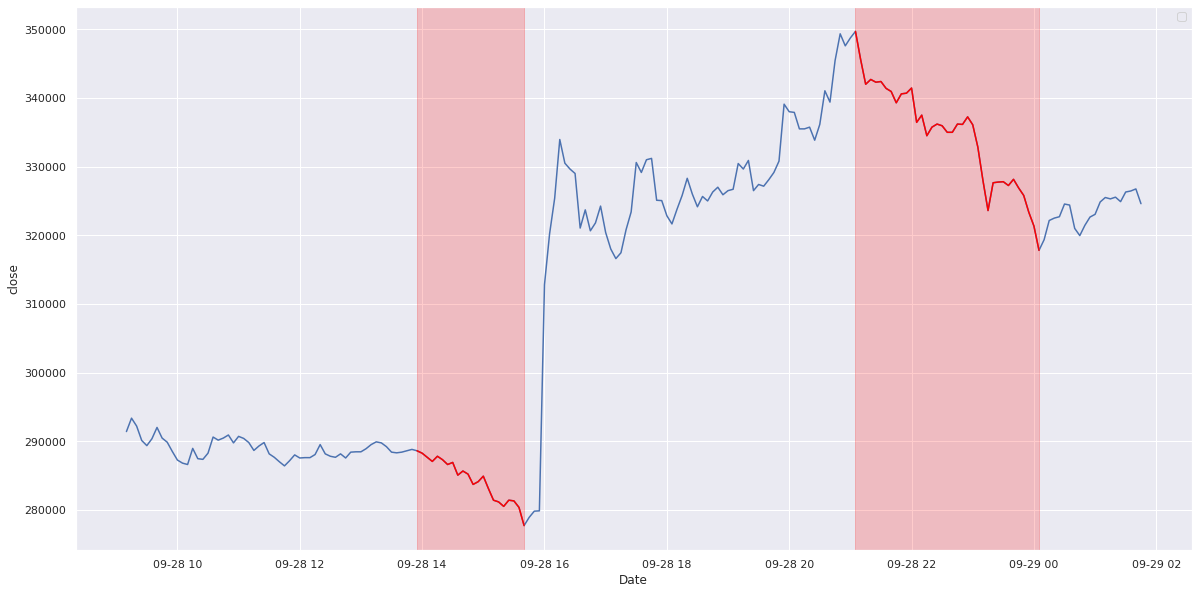

In [ ]:
##### detecting downtrend using trendet funciton

# import trendet
import seaborn as sns
import matplotlib.dates as md


sns.set(style='darkgrid')

df = identify_all_trends(xrp_data_5, window_size=20, identify='down')
# df = identify_all_trends(xrp_data, window_size=10, identify='both')


# df = trendet.identify_all_trends(stock='BBVA',
#                                  country='Spain',
#                                  from_date='01/01/2018',
#                                  to_date='01/01/2019',
#                                  window_size=5,
#                                  identify='both')

# df.reset_index(drop=True, inplace=True)
# ax.xaxis_date()
# xfmt = md.DateFormatter('%H:%M:%S')
# ax.xaxis.set_major_formatter(xfmt)

plt.figure(figsize=(20, 10))

ax = sns.lineplot(x=df.index, y=df['close'])
ax.set(xlabel='Date')

# labels = df['Up Trend'].dropna().unique().tolist()

# for label in labels:
#     sns.lineplot(x=df[df['Up Trend'] == label].index,
#                  y=df[df['Up Trend'] == label]['close'],
#                  color='green')

#     ax.axvspan(df[df['Up Trend'] == label].index[0],
#                df[df['Up Trend'] == label].index[-1],
#                alpha=0.2,
#                color='green')

labels = df['Down Trend'].dropna().unique().tolist()

for label in labels:
    sns.lineplot(x=df[df['Down Trend'] == label].index,
                 y=df[df['Down Trend'] == label]['close'],
                 color='red')

    ax.axvspan(df[df['Down Trend'] == label].index[0],
               df[df['Down Trend'] == label].index[-1],
               alpha=0.2,
               color='red')
               
# locs, _ = plt.xticks()
# labels = []

# for position in locs[1:-1]:
#     labels.append(str(df['Date'].loc[position])[:-9])

# plt.xticks(locs[1:-1], labels)

# ax.plot(ma(xrp_data['close'], 50), label="ma_50")
min_close = xrp_data_5['close'].min()
range_close = xrp_data_5['close'].max() - xrp_data_5['close'].min()
# ax.plot(ratio(xrp_rsi,range_close, min_close), label="rsi")
# ax.plot(ratio(xrp_mfi,range_close, min_close), label="mfi") 
# ax.plot(ratio(xrp_obv,800, 9000), label="obv") 


# df=my_data.copy()
# df.reset_index(drop=True, inplace=True)
# ax.plot(df['close'].loc[df['value'] ==1], '^', markersize=7, color='g')

# ax.scatter(df[df['value'] ==1].index,df['close'].loc[df['value'] ==1], label='skitscat', color='green', s=25, marker="^")


ax.legend()

plt.show()

In [ ]:
## time length of recent down trend
## in 5min  

order = 1

min5_len = len_recent_trend(identify_all_trends(xrp_data_5, window_size=15, identify='down'), count_order=order, trend_type="Down Trend", min_length=5)
last_date = last_date_downtrend(identify_all_trends(xrp_data_5, window_size=15, identify='down'), count_order=order, trend_type="Down Trend", min_length=5)
print(min5_len)
print(last_date)
datestring = (last_date-datetime.timedelta(hours=9)).strftime("%Y%m%d%H%M%S")


## in 1min
print(min5_len*5)

37
2021-09-29 00:05:00
185


In [ ]:
now = datetime.datetime.now()
fmt = '%Y-%m-%d %H:%M:%S'
tstamp1 = datetime.datetime.strptime(str(last_date), fmt)
tstamp2 = datetime.datetime.strptime(now, fmt)

time_delta = now+datetime.timedelta(hours=9)-last_date
secs = time_delta.total_seconds()
print (now)
print(tstamp1)
print(tstamp2)

print(time_delta)

TypeError: ignored

In [ ]:

'images_succeed/success_'+coin+'_'+str(min5_len)+'_'+datestring+'.png'

'images_succeed/success_KRW-HIVE_129_20210927124500.png'

In [ ]:
max(xrp_data_5['high'].loc[last_date:]) >100

True

1


In [ ]:
# test drawing mfi, rsi, and obv for KRW-XRP
# from pyti.money_flow_index import money_flow_index as mfi

datestring = (last_date-datetime.timedelta(hours=9)).strftime("%Y%m%d%H%M%S")
xrp_data = get_data(coin, interval="minute1", count=(min5_len+1)*5,to=datestring).drop_duplicates() #extracting 5 minutes more than 5*min5_len, in order to calculate ma5 in minute1
print("length of xrp_data is: ", len(xrp_data))
price_ma = ma(np.array(xrp_data['close']), 14)
xrp_rsi = rsi_ewm_np(xrp_data.iloc[:,[3]], 14)
xrp_mfi = money_flow_index(xrp_data, 14, types=3)
xrp_obv = on_balance_volume(xrp_data.iloc[:,[3,4]])

In [ ]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing  = 0.03)
data=fit_frame(xrp_data)

fig.add_trace(go.Candlestick(x = data['time'],
                            open = xrp_data['open'],
                            close = xrp_data['close'],
                            low = xrp_data['low'],
                            high = xrp_data['high'],
                             name='price'),
              row = 1, col = 1)

fig.add_trace(go.Scatter(
    x = data['time'],
    y=xrp_rsi,
    name="rsi"),
    row=2, col=1
)

fig.add_trace(go.Scatter(
    x = data['time'],
    y=xrp_mfi,
    name="mfi"),
    row=3, col=1
)

fig.add_trace(go.Scatter(
    x = data['time'],
    y=xrp_obv,
    name="obv"),
    row=4, col=1
)

fig.update_xaxes(row=1, col=1, rangeslider_thickness=0.0, type="date")
fig.update_xaxes(row=2, col=1, rangeslider_thickness=0.0, type="date")
fig.update_xaxes(row=3, col=1, rangeslider_thickness=0.0, type="date")
fig.update_xaxes(row=4, col=1, rangeslider_thickness=0.05, type="date")

fig.update_yaxes(title_text="price", row=1, col=1)
fig.update_yaxes(title_text="rsi", row=2, col=1)
fig.update_yaxes(title_text="mfi", row=3, col=1)
fig.update_yaxes(title_text="obv", row=4, col=1)

# fig.update_traces(row=1, col=1, shapes = FindTrends(data, n=20, distance_factor=0.01))
 

shapes1 = Find_MinEnvelope(xrp_data.index, np.array(xrp_data['close']), num_subplot=1)
shapes2 = Find_MinEnvelope(xrp_data.index, xrp_rsi, num_subplot=2)
shapes3 = Find_MinEnvelope(xrp_data.index, xrp_mfi, num_subplot=3)
shapes4 = Find_MinEnvelope(xrp_data.index, np.array(xrp_obv), num_subplot=4)
# shapes1 = Find_MinEnvelope(xrp_data.index, np.array(xrp_data['close']), num_subplot=1)
# shapes1 = FindTrends(fit_frame(xrp_data),xrp_rsi<40, n=4, distance_factor=min5_len/15000, num_subplot=1, mode='min')
# shapes2 = FindTrends(fit_np(xrp_rsi,xrp_data.index),xrp_rsi<40, n=4, distance_factor=1/(5*min5_len), num_subplot=2, mode='min')
# shapes3 = FindTrends(fit_np(xrp_mfi,xrp_data.index),xrp_rsi<40, n=4, distance_factor=1/(5*min5_len), num_subplot=3, mode='min')



fig.update_layout(width=900,height=1000,
                  title={
                      'text': "KRW-XRP, minute1",
                      'y':0.97,
                      'x':0.5,
                      'xanchor': 'center',
                      'yanchor': 'top'},

                  shapes=shapes1+shapes2+shapes3+shapes4)
                  # shapes=shapes2+shapes3+shapes4)

# fig['layout'].update(shapes=shapes)
fig.show()


# av = int(np.mean(xrp_data['close']))
# av_round = int(str(av)[0]+str(av)[1])*(10**(len(str(av))-2))

# fig.add_trace(go.Scatter(
#     x=xrp_data.index,
#     y=xrp_data['ror']*av_round,
#     name="ror"
# ))

# type(xrp_data.index[0])

NameError: ignored

In [ ]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3753    0  3753    0     0   8647      0 --:--:-- --:--:-- --:--:--  8667
100  503k  100  503k    0     0   464k      0  0:00:01  0:00:01 --:--:-- 1026k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3745    0  3745    0     0   8959      0 --:--:-- --:--:-- --:--:--  8937
100  406k  100  406k    0     0   373k      0  0:00:01  0:00:01 --:--:--  373k


In [ ]:
morning_star = talib.CDLMORNINGSTAR(xrp_data_5['open'], xrp_data_5['high'], xrp_data_5['low'], xrp_data_5['close'])
engulfing = talib.CDLENGULFING(xrp_data['open'], xrp_data['high'], xrp_data['low'], xrp_data['close'])


# morning_star[morning_star>0]
engulfing[engulfing>0].index

DatetimeIndex(['2021-09-26 09:15:00', '2021-09-26 12:55:00'], dtype='datetime64[ns]', freq=None)

In [ ]:
import matplotlib.dates as mdates

def save_fig(coin, xrp_data, xrp_obv, xrp_rsi, xrp_mfi, filename):
    x_axis = xrp_data.index.to_pydatetime()[5:]
    norm_price = norm(xrp_data['close'])
    norm_obv = norm(xrp_obv)
    norm_rsi = xrp_rsi/100
    norm_mfi = xrp_mfi/100
    # norm_d_obv_price = norm_obv-norm_price
    # norm_d_mfi_rsi = norm_mfi - norm_rsi

    # global_minima = gather_minima(norm_price, norm_obv, norm_rsi, norm_mfi)  # index is based on time axis with first 5 truncated, so use x_axis as above
    price_obv_global = price_obv_minima(norm_price, norm_obv)  # index is based on time axis with first 5 truncated, so use x_axis as above
    rsi_mfi_global = rsi_mfi_minima(norm_rsi, norm_mfi)  # index is based on time axis with first 5 truncated, so use x_axis as above

    fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(6, 1, sharex=True, figsize = (6,10))
    fig.tight_layout(pad=1)

    fig.suptitle('Recent data for '+coin, y=1.03)
    ax1.plot(x_axis, norm_price[5:], 'black')
    ax2.plot(x_axis, norm_obv[5:], 'brown')
    ax3.plot(x_axis, norm_rsi[5:], 'darkblue')
    ax4.plot(x_axis, norm_mfi[5:], 'purple')
    # ax5.plot(x_axis, norm_d_obv_price[5:], 'red')
    # ax6.plot(x_axis, norm_d_mfi_rsi[5:], 'red')


    ax1.title.set_text('Norm_price')
    ax2.title.set_text('Norm_obv')
    ax3.title.set_text('RSI')
    ax4.title.set_text('MFI')
    ax5.title.set_text('slope(OBV-Price)')
    ax6.title.set_text('slope(MFI-RSI)')

    ax1.grid(True, axis='x', color='b' )
    ax2.grid(True, axis='x', color='b' )
    ax3.grid(True, axis='x', color='b' )
    ax4.grid(True, axis='x', color='b' )
    ax5.grid(True, axis='x', color='b' )  
    ax6.grid(True, axis='x', color='b' )

    ax1.set_ylim([-1, 0])
    ax2.set_ylim([-1, 0])
    ax3.set_ylim([0, 1])
    ax4.set_ylim([0, 1])

    slopes_diff = [0]
    for index in range(len(price_obv_global)-1):
      time_index = price_obv_global[index]
      next_time_index = price_obv_global[index+1]
      x1 = x_axis[time_index]
      x2 = x_axis[next_time_index]

      price_y1 = norm_price[5:][time_index]
      price_y2 = norm_price[5:][next_time_index]
      obv_y1 = norm_obv[5:][time_index]
      obv_y2 = norm_obv[5:][next_time_index]

      slope_price = get_slope([x1,price_y1],[x2,price_y2])
      slope_obv = get_slope([x1,obv_y1],[x2,obv_y2])
      slopes_diff.append(1000*(slope_obv-slope_price))

      ax1.plot([x1,x2],[price_y1,price_y2], 'co--')
      ax2.plot([x1,x2],[obv_y1,obv_y2], 'co--')
      ax5.plot([x1,x2],[slopes_diff[index],slopes_diff[index+1]], 'ko--')
      # ax5.plot([x1,x2],[norm_d_obv_price[5:][time_index],norm_d_obv_price[5:][next_time_index]], 'ko--')

    slopes_diff = [0]
    for index in range(len(rsi_mfi_global)-1):
      time_index = rsi_mfi_global[index]
      next_time_index = rsi_mfi_global[index+1]
      x1 = x_axis[time_index]
      x2 = x_axis[next_time_index]

      rsi_y1 = norm_rsi[5:][time_index]
      rsi_y2 = norm_rsi[5:][next_time_index]
      mfi_y1 = norm_mfi[5:][time_index]
      mfi_y2 = norm_mfi[5:][next_time_index]

      slope_rsi = get_slope([x1,rsi_y1],[x2,rsi_y2])
      slope_mfi = get_slope([x1,mfi_y1],[x2,mfi_y2])
      slopes_diff.append(1000*(slope_mfi-slope_rsi))

      ax3.plot([x1,x2],[rsi_y1,rsi_y2], 'ro--')
      ax4.plot([x1,x2],[mfi_y1,mfi_y2], 'ro--')
      ax6.plot([x1,x2],[slopes_diff[index],slopes_diff[index+1]], 'ko--')
      # ax6.plot([x1,x2],[norm_d_mfi_rsi[5:][time_index],norm_d_mfi_rsi[5:][next_time_index]], 'ko--')

    ax5.axhline(y = 0, color = 'r', linestyle = '-')
    ax6.axhline(y = 0, color = 'r', linestyle = '-')


    # for index in range(len(global_minima)-1):
    #   time_index = global_minima[index]
    #   next_time_index = global_minima[index+1]
    #   x1 = x_axis[time_index]
    #   x2 = x_axis[next_time_index]
    #   price_y1 = norm_price[5:][time_index]
    #   price_y2 = norm_price[5:][next_time_index]
    #   obv_y1 = norm_obv[5:][time_index]
    #   obv_y2 = norm_obv[5:][next_time_index]
    #   rsi_y1 = norm_rsi[5:][time_index]
    #   rsi_y2 = norm_rsi[5:][next_time_index]
    #   mfi_y1 = norm_mfi[5:][time_index]
    #   mfi_y2 = norm_mfi[5:][next_time_index]

    #   ax1.plot([x1,x2],[price_y1,price_y2], 'co--')
    #   ax2.plot([x1,x2],[obv_y1,obv_y2], 'co--')
    #   ax3.plot([x1,x2],[rsi_y1,rsi_y2], 'ro--')
    #   ax4.plot([x1,x2],[mfi_y1,mfi_y2], 'ro--')
    #   ax5.plot([x1,x2],[norm_d_obv_price[5:][time_index],norm_d_obv_price[5:][next_time_index]], 'ko--')
    #   ax6.plot([x1,x2],[norm_d_mfi_rsi[5:][time_index],norm_d_mfi_rsi[5:][next_time_index]], 'ko--')

    date_form = mdates.DateFormatter('%m-%d %H:%M')
    ax1.xaxis.set_major_formatter(date_form)
    # ax2.xaxis.set_major_formatter(date_form)
    # ax3.xaxis.set_major_formatter(date_form)
    # ax4.xaxis.set_major_formatter(date_form)

    fig.autofmt_xdate()

    fig.savefig(filename, bbox_inches='tight')   # save the figure to file
    plt.close(fig)    # close the figure window

    # ax1.set_xticklabels(["one", "two", "three", "four"], rotation=45)


In [ ]:
def get_slopes (x_axis, minima, norm_data):
  slopes = []
  for index in range(len(minima)-1):
    time_index = minima[index]
    next_time_index = minima[index+1]
    x1 = x_axis[time_index]
    x2 = x_axis[next_time_index]

    price_y1 = norm_data[5:][time_index]
    price_y2 = norm_data[5:][next_time_index]

    slopes.append(get_slope([x1,price_y1],[x2,price_y2]))

  return slopes

In [ ]:
get_slopes(x_axis, price_obv_global, norm_obv)

[-0.00014, -3e-05, -9e-05, -7e-05, -4e-05, 0.00046]

In [ ]:
save_fig(xrp_data, xrp_obv, xrp_rsi, xrp_mfi, 'images/fig2.png')

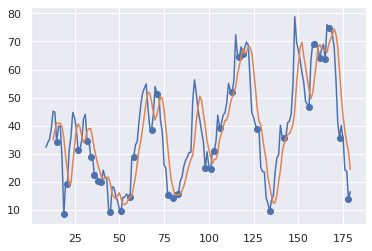

In [ ]:
times = xrp_data.index
close_nparray = xrp_mfi
# close_nparray = np.array(xrp_data['close'])

real_price = close_nparray[5:]
min_peaks_x = find_peaks(-real_price, )[0]
# min_peaks_x = argrelextrema(real_price, np.less, order=1)[0]
min_peaks_y = real_price[min_peaks_x]

plt.plot(real_price)
plt.plot(ma(close_nparray,5)[5:])
plt.scatter(min_peaks_x,min_peaks_y)
# plt.scatter([point['x_grid'] for point in trendPoints], [point['y_price'] for point in trendPoints])

In [ ]:
print(xrp_data_5['close'][0], xrp_data_5['volume'][0])

262900.0 1056.75913056


In [ ]:
start

datetime.datetime(2021, 9, 27, 14, 40, 15, 652618)

In [ ]:
def find_index(lst, key, value):
    index_lst = []
    for i, dic in enumerate(lst):
        if dic[key] == value:
            index_lst.append(i)
    return np.array(index_lst)

In [ ]:
import csv

header = ['coin','sum_vol*close', 'time_len_5min_down', 'last_date_5min_down', 'engulfing_1min','morningstar_1min', 'price_obv_minima', 'mfi_rsi_minima',
'slopes_1min_price','slopes_1min_obv','slopes_1min_rsi','slopes_1min_mfi','buy_price','time_to_1per']

header_all = ['coin','sum_vol*close', 'time_len_5min_down', 'last_date_5min_down', 'buy_price']

with open('coin_track_succeed.csv', 'a', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)
    # write multiple rows

with open('coin_track_all.csv', 'a', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header_all)


total_df = {}
tickers = pyupbit.get_tickers(fiat="KRW")

start = datetime.datetime.now() + datetime.timedelta(hours=9)
t = timeit.default_timer()

print("starting time is ", start)
for i in range(len(tickers)):
    one_coin = get_data(tickers[i], interval="minute5", count=200).drop_duplicates()[:-2]
    total_df[tickers[i]] = one_coin
    # time.sleep(random.randint(1, 10)/17)

end = (datetime.datetime.now()+ datetime.timedelta(hours=9)).time()
t2 = timeit.default_timer() - t
print("ended at ", end, "difference for getting data is ", t2)


time_checkpoint = total_df['KRW-BTC'].index[-1] + datetime.timedelta(minutes=10)   #****should be twice the interval!!
# trade_df = np.empty([1, ??? ])

tracking_coins = ["KRW-BTC"]
tracking_df = [[0,0,0,0,0,0,0,0,0,0,0,0,0,0]]

# run code in an designated unit
# try:
now = datetime.datetime.now() + datetime.timedelta(hours=9)
print("-------now time is ", now, "checkpoint is ", time_checkpoint)
print(" ")
print(" ")









# do this job evey 1 unit
# update total_df by adding data from the last hour
print("-------updating data--------------")
tickers = pyupbit.get_tickers(fiat="KRW")
filtered_by_key = {key: total_df[key]['volume'][-1]*total_df[key]['close'][-1] for key in tickers}
tickers = [a_tuple[0] for a_tuple in sorted(filtered_by_key.items(), key=lambda x: x[1])]  #filter from lower volume to high, in order to prevent update loss (although we check timecheckpoint)

# print(tickers)
start = datetime.datetime.now()+ datetime.timedelta(hours=9)
t = timeit.default_timer()

print("starting time is ", start)
for i in range(len(tickers)):
    # isit_uptodate = time_checkpoint
    # while isit_uptodate != (time_checkpoint - datetime.timedelta(hours=1)):            #initial value would be 1 hour ago beacuse when it was called last was before loop
    #     one_coin_data = pd.DataFrame(pyupbit.get_ohlcv(tickers[i], interval="minute60", count=2))
    #     print(one_coin_data)
    #     one_coin = one_coin_data.iloc[0]
    #     isit_uptodate = one_coin.name
    check = 1
    while check > 0:
        try:
            one_coin_data = pyupbit.get_ohlcv(tickers[i], interval="minute5", count=2)   #due to delayed update, this might be either [now-2,now-1] or [now-1, now] so we need to filter
            check -= 1    
        except Exception as e:
            print(e)
            print('Restarting get_ohlcv for update_line 830!')
            continue            

    if one_coin_data.index[-1] == (time_checkpoint - datetime.timedelta(minutes=5)):   #if [now-2, now-1]
        one_coin = one_coin_data.iloc[1]
        total_df[tickers[i]] = total_df[tickers[i]].iloc[1:].append(one_coin).drop_duplicates()
        # if tickers[i] in ["KRW-BTC","KRW-MTL","KRW-NEO","KRW-IOST","KRW-EFL", "KRW-ETH", "KRW-ARK"]:
        if tickers[i] in ["KRW-BTC", "KRW-DOT"]:
            print(total_df[tickers[i]].iloc[[0,1,-2,-1]])
            print(" ")
            print(pd.DataFrame(one_coin).T)                

    elif one_coin_data.index[-1] == time_checkpoint:   #if [now-1, now]
        one_coin = one_coin_data.iloc[0]
        total_df[tickers[i]] = total_df[tickers[i]].iloc[1:].append(one_coin).drop_duplicates()
        # if tickers[i] in ["KRW-BTC","KRW-MTL","KRW-NEO","KRW-IOST","KRW-EFL", "KRW-ETH", "KRW-ARK"]:
        if tickers[i] in ["KRW-BTC","KRW-DOT"]:
            print(total_df[tickers[i]].iloc[[0,1,-2,-1]])
            print(" ")
            print(pd.DataFrame(one_coin).T)

    else:
        print("something's wrong with updating for coin: ", tickers[i])
        print(total_df[tickers[i]].iloc[[0,1,-2,-1]])
          

    time.sleep(random.randint(1, 10)/30)


end = (datetime.datetime.now()+ datetime.timedelta(hours=9)).time()
# print_to_slack({key: len(total_df[key]['volume']) for key in tickers})
print("ended at ", end, "difference for getting data is ",
      timeit.default_timer() - t)

down_coins_min5 = []    # list of dictionaries






one_coin_dict['last_date_5min_down'] = last_date
one_coin_dict['time_len_5min_down'] = min5_len
## finding
for coin in tickers:
    dicts_coin = [d for d in down_coins_min5 if d['coin'] in [coin]]   #mini dict
    dicts_index = find_index(down_coins_min5, 'coin', coin)            #gross index of each mini dict
    coin_data_5 = total_df[coin]

    for coin_dict_index in range(len(dicts_coin)):
        one_coin_dict = dicts_coin[coin_dict_index]

        if len(coin_data_5.loc[one_coin_dict['last_date_5min_down']:]) >= 3:
            high_data_from_last_date = coin_data_5['high'].loc[one_coin_dict['last_date_5min_down']+datetime.timedelta(minutes=10):]
            max_high_from_last_date = max(high_data_from_last_date)
        else:
            high_data_from_last_date = coin_data_5['high'].loc[one_coin_dict['last_date_5min_down']+datetime.timedelta(minutes=5):]
            max_high_from_last_date = max(high_data_from_last_date)

        gross_index = dicts_index[coin_dict_index]
        
        now = datetime.datetime.now()
        last_date = one_coin_dict['last_date_5min_down']
        min5_len = one_coin_dict['time_len_5min_down']
        
        if max_high_from_last_date > one_coin_dict['buy_price']*1.01:
            # del down_coins_min5[gross_index]                    ####**important

            # datestring = (last_date-datetime.timedelta(hours=9)).strftime("%Y%m%d%H%M%S")
            datestring = last_date.strftime("%Y%m%d%H%M%S")
            coin_data_1min = get_data(coin, interval="minute1", count=(min5_len+1)*5,to=datestring) #extracting 5 minutes more than 5*min5_len, in order to calculate ma5 in minute1
            
            # print("length of xrp_data is: ", len(xrp_data))
            x_axis = coin_data_1min.index.to_pydatetime()[5:]
            
            coin_rsi = rsi_ewm_np(coin_data_1min.iloc[:,[3]], 14)
            coin_mfi = money_flow_index(coin_data_1min, 14, types=3)
            coin_obv = on_balance_volume(coin_data_1min.iloc[:,[3,4]])

            norm_price = norm(coin_data_1min['close'])
            norm_obv = norm(coin_obv)
            norm_rsi = coin_rsi/100
            norm_mfi = coin_mfi/100                
            
            price_obv_global = price_obv_minima(norm_price, norm_obv)
            rsi_mfi_global = rsi_mfi_minima(norm_rsi, norm_mfi)  # index is based on time axis with first 5 truncated, so use x_axis as above

            slopes_1min_price = get_slopes(x_axis, price_obv_global, norm_price)
            slopes_1min_obv = get_slopes(x_axis, price_obv_global, norm_obv)
            slopes_1min_rsi = get_slopes(x_axis, rsi_mfi_global, norm_rsi)
            slopes_1min_mfi = get_slopes(x_axis, rsi_mfi_global, norm_mfi)

            engulfing = talib.CDLENGULFING(coin_data_1min['open'], coin_data_1min['high'], coin_data_1min['low'], coin_data_1min['close'])
            morning_star = talib.CDLENGULFING(coin_data_1min['open'], coin_data_1min['high'], coin_data_1min['low'], coin_data_1min['close'])

            time_to_1per = now - last_date
            new_line = []
            new_line.extend([coin, one_coin_dict['sum'], min5_len, last_date])
            new_line.append(engulfing[engulfing>0].index)
            new_line.append(morning_star[morning_star>0].index)
            new_line.extend([x_axis[price_obv_global], x_axis[rsi_mfi_global], slopes_1min_price, slopes_1min_obv, slopes_1min_rsi, slopes_1min_mfi, one_coin_dict['buy_price'], time_to_1per])
            

            with open('coin_track_succeed.csv', 'a', encoding='UTF8', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(new_line)       
            
            file_path_png = 'images/success_'+coin+'_'+str(min5_len)+'_'+datestring+'.png'
            save_fig(coin, coin_data_1min, coin_obv, coin_rsi, coin_mfi, file_path_png)
            # post_image(comment=str(coin)+" time: "+str(time_to_1per)+"@here", filepath =file_path_png)
    
        else:   #no max is higher than the buy price ==> in this case, add not succeded in result if time difference between now and last_date > 200*5 minutes
            # now = datetime.datetime.now()
            time_diff_from_last_date = now - last_date
            secs_from_last_date = time_diff_from_last_date.total_seconds()

            if round(secs_from_last_date) > 200*5*60:
                datestring = last_date.strftime("%Y%m%d%H%M%S")
                coin_data_1min = get_data(coin, interval="minute1", count=(min5_len+1)*5,to=datestring) #extracting 5 minutes more than 5*min5_len, in order to calculate ma5 in minute1
                
                # print("length of xrp_data is: ", len(xrp_data))
                x_axis = coin_data_1min.index.to_pydatetime()[5:]
                
                coin_rsi = rsi_ewm_np(coin_data_1min.iloc[:,[3]], 14)
                coin_mfi = money_flow_index(coin_data_1min, 14, types=3)
                coin_obv = on_balance_volume(coin_data_1min.iloc[:,[3,4]])

                norm_price = norm(coin_data_1min['close'])
                norm_obv = norm(coin_obv)
                norm_rsi = coin_rsi/100
                norm_mfi = coin_mfi/100                
                
                price_obv_global = price_obv_minima(norm_price, norm_obv)
                rsi_mfi_global = rsi_mfi_minima(norm_rsi, norm_mfi)  # index is based on time axis with first 5 truncated, so use x_axis as above

                slopes_1min_price = get_slopes(x_axis, price_obv_global, norm_price)
                slopes_1min_obv = get_slopes(x_axis, price_obv_global, norm_obv)
                slopes_1min_rsi = get_slopes(x_axis, rsi_mfi_global, norm_rsi)
                slopes_1min_mfi = get_slopes(x_axis, rsi_mfi_global, norm_mfi)

                engulfing = talib.CDLENGULFING(coin_data_1min['open'], coin_data_1min['high'], coin_data_1min['low'], coin_data_1min['close'])
                morning_star = talib.CDLENGULFING(coin_data_1min['open'], coin_data_1min['high'], coin_data_1min['low'], coin_data_1min['close'])

                failed = "Failed"
                new_line = []
                new_line.extend([coin, one_coin_dict['sum'], min5_len, last_date])
                new_line.append(engulfing[engulfing>0].index)
                new_line.append(morning_star[morning_star>0].index)
                new_line.extend([x_axis[price_obv_global], x_axis[rsi_mfi_global], slopes_1min_price, slopes_1min_obv, slopes_1min_rsi, slopes_1min_mfi, one_coin_dict['buy_price'], failed])
                

                with open('coin_track_failed.csv', 'a', encoding='UTF8', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow(new_line)       

                file_path_png = 'images/fail_'+coin+'_'+str(min5_len)+'_'+datestring+'.png'
                save_fig(coin, coin_data_1min, coin_obv, coin_rsi, coin_mfi, file_path_png)
                post_image(comment=str(coin)+" "+failed+"@here", filepath =file_path_png)
    
    coin_data_5 = total_df[coin]
    order = 1
    try:
        identified_data = identify_all_trends(coin_data_5, window_size=15, identify='down')
        min5_len = len_recent_trend(identified_data, count_order=order, trend_type="Down Trend", min_length=5)
        last_date = last_date_downtrend(identified_data, count_order=order, trend_type="Down Trend", min_length=5)
        last_identifier = identified_data.iloc[-1]['Down Trend']
        second_to_last_identifier = identified_data.iloc[-2]['Down Trend']                

        if pd.isna(last_identifier) & (not pd.isna(second_to_last_identifier)):
            print("down coin candidate", coin,", min length: ", min5_len,", last date: ", last_date)
            sum_vol_price = sum(coin_data_5['close']*coin_data_5['volume'])
            last_ticks5 = get_recent_tick5(coin)                    
            # print_to_slack(orderbook)
            ask_price_ = max([x['TradePrice'] for x in last_ticks5])
            bid_price_ = min([x['TradePrice'] for x in last_ticks5])
            bid_price = bid_price_ if bid_price_ <= ask_price_ else (bid_price_+ask_price_)/2
            ask_price = ask_price_ if bid_price_ <= ask_price_ else (bid_price_+ask_price_)/2

            coin_down_dict_min5 = {"coin": coin, "sum": sum_vol_price, 'last_date_5min_down':last_date, "time_len_5min_down": min5_len, 'buy_price': bid_price} 
            down_coins_min5.append(coin_down_dict_min5)
            with open('coin_track_all.csv', 'a', encoding='UTF8', newline='') as f:
                writer = csv.writer(f)

                # write the header ['coin','sum_vol*close', 'time_len_5min_down', 'last_date_5min_down', 'buy_price']
                writer.writerow([coin, sum_vol_price, min5_len,last_date, bid_price])

    except Exception:
        pass

length_dict = {key: len(value) for key, value in total_df.items()}

for coin in tickers:
    coin_data_tmp = total_df[coin]
    
    if length_dict[coin]>199:
        total_df[coin] = coin_data_tmp.iloc[-199:]   #delete an old row of data




In [ ]:
high_data_from_last_date

2021-09-29 01:10:00    7160.0
2021-09-29 01:15:00    7140.0
Name: high, dtype: float64

In [ ]:
# trace1 = go.Scatter(
#     x=[10, 20, 30],
#     y=[40, 50, 60]
# )
# trace2 = go.Scatter(
#     x=[20, 30, 40],
#     y=[50, 60, 70]
# )
# trace3 = go.Scatter(
#     x=[30, 40, 50],
#     y=[60, 70, 80]
# )
# trace4 = go.Scatter(
#     x=[40, 50, 60],
#     y=[70, 80, 90]
# )
# shapes = [
#     {'type': 'line', 'x0': 25, 'y0': 100, 'x1': 35, 'y1': 100, 'xref': 'x1', 'yref': 'y1'},
#     {'type': 'line', 'x0': 25, 'y0': 200, 'x1': 35, 'y1': 200, 'xref': 'x2', 'yref': 'y2'},
#     {'type': 'line', 'x0': 25, 'y0': 300, 'x1': 35, 'y1': 300, 'xref': 'x3', 'yref': 'y3'},
#     {'type': 'line', 'x0': 25, 'y0': 400, 'x1': 35, 'y1': 400, 'xref': 'x4', 'yref': 'y4'}
# ]

# fig = make_subplots(rows=2, cols=2)
# fig.append_trace(trace1, 1, 1)
# fig.append_trace(trace2, 1, 2)
# fig.append_trace(trace3, 2, 1)
# fig.append_trace(trace4, 2, 2)

# fig['layout'].update(shapes=shapes)

# fig.show()

In [ ]:
### finding minimum points 

In [ ]:
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing  = 0.03)
# data=fit_frame(xrp_data)

# trace1=go.Candlestick(x = data['time'],
#                             open = data['open'],
#                             close = data['close'],
#                             low = data['low'],
#                             high = data['high'],
#                              name='price')
#                             #  row = 1, col = 1)

# trace2=go.Scatter(
#     x=data['time'],
#     y=xrp_rsi,
#     xaxis="x",
#     name="rsi")
# #     row=2, col=1
# # )

# trace3=go.Scatter(
#     x=data['time'],
#     y=xrp_mfi,
#     xaxis="x",
#     name="mfi")
# #     row=3, col=1
# # )

# trace4=go.Scatter(
#     x=data['time'],
#     y=xrp_obv,
#     xaxis="x",
#     name="obv")
# #     row=4, col=1
# # )

# # fig.update_xaxes(row=1, col=1, rangeslider_thickness=0.0)
# # fig.update_xaxes(row=2, col=1, rangeslider_thickness=0.0)
# # fig.update_xaxes(row=3, col=1, rangeslider_thickness=0.0)
# # fig.update_xaxes(row=4, col=1, rangeslider_thickness=0.05)

# # fig.update_yaxes(title_text="price", row=1, col=1)
# # fig.update_yaxes(title_text="rsi", row=2, col=1)
# # fig.update_yaxes(title_text="mfi", row=3, col=1)
# # fig.update_yaxes(title_text="obv", row=4, col=1)

# # fig.update_layout(width=800,height=1000,
# #                   title={
# #                       'text': "KRW-XRP, minute5",
# #                       'y':0.9,
# #                       'x':0.5,
# #                       'xanchor': 'center',
# #                       'yanchor': 'top'})
# layout = go.Layout(
# 		xaxis = {
# 			"title" : "price",
# 			"rangeslider" : {"visible": False},
# 			"type" : "date"
# 		},
# 		yaxis = {
# 			"fixedrange" : False,
# 		},
#     shapes = FindTrends(data, n=20, distance_factor=0.01),
# 		yaxis2 = {
# 			"fixedrange" : False,
# 		},
# 		yaxis3 = {
# 			"fixedrange" : False,
# 		},
# 		yaxis4 = {
# 			"fixedrange" : False,
# 		})
#     # yaxis2=dict(
#     #     domain=[0.55, 1],
#     #     anchor="x4"
#     # )

# data = [trace1, trace2, trace3, trace4]
# fig = go.Figure(data=data, layout=layout)

# fig.show()


# # av = int(np.mean(xrp_data['close']))
# # av_round = int(str(av)[0]+str(av)[1])*(10**(len(str(av))-2))

# # fig.add_trace(go.Scatter(
# #     x=xrp_data.index,
# #     y=xrp_data['ror']*av_round,
# #     name="ror"
# # ))

In [ ]:
def divergence(input_data, indicator, lower_barrier, upper_barrier, width): 
    Data = input_data.copy()
    try:
      for i in range(len(Data)):
            if indicator[i] < lower_barrier:
                for a in range(i + 1, i + width):
                    # First trough
                    if indicator[a] > lower_barrier:
                        for r in range(a + 1, a + width):
                            if indicator[r] < lower_barrier and indicator[r] > indicator[i] and Data['close'][r] < Data['close'][i]:
                                for s in range(r + 1, r + width):

                                    # Second trough
                                    if indicator[s] > lower_barrier:
                                        Data['value'][s] = 1
                                        break
                                    else:
                                        break
                            else:
                                break
                        else:
                            break
                    else:
                        break
    except IndexError:
      pass

    # for i in range(len(Data)):
    #     if Data[i, indicator] > upper_barrier:
    #         for a in range(i + 1, i + width):
    #             # First trough
    #             if Data[a, indicator] < upper_barrier:
    #                 for r in range(a + 1, a + width):
    #                     if Data[r, indicator] > upper_barrier and Data[r, indicator] < Data[i, indicator] and Data[r, 3] > Data[i, 3]:
    #                         for s in range(r + 1, r + width):
    #                             # Second trough
    #                             if Data[s, indicator] < upper_barrier:
    #                                 Data[s, sell] = -1
    #                                 break
    #                             else:
    #                                 break
    #                     else:
    #                         break
    #                 else:
    #                     break
    #             else:
    #                 break
 
    return Data

In [ ]:
lower_barrier = 30
upper_barrier = 70
width         = 30
# Detecting divergences
my_data = divergence(xrp_data, xrp_mfi, lower_barrier, upper_barrier, width)

In [ ]:
xrp_data

In [ ]:
plt.figure(figsize=(20, 10))
df=xrp_data.copy()

plt.plot(df['close'])
df['min'] = df.iloc[np.intersect1d(argrelextrema(df.close.values, np.less_equal, order=4)[0], np.where(xrp_rsi<40)[0])]['close']


# plt.plot(buys.index, data.ix[buys.index]['Settle'], '^', markersize=10, color='g')
# plt.plot(df['close'].loc[df['value'] ==1], '^', markersize=7, color='g')
plt.plot(df['min'], '^', markersize=7, color='g')

# plt.plot(df[df['value'] ==1].index,df['close'].loc[df['value'] ==1], label='skitscat', color='green', s=25, marker="^")
# plt.scatter(df.loc[df['Sell_ind'] ==1 , 'Date'].values,df.loc[df['Sell_ind'] ==1, 'Close Price'].values, label='skitscat', color='red', s=25, marker="v")

plt.show()

In [ ]:
######## Plotter ##########
import plotly.graph_objs as go
from plotly.offline import plot

# As you can see, the only thing this class does is plot data, so we will remove all
# unnecessary elements, and only leave the essential.

def PlotIndicator(df, plot_title:str="", trends = False):
  data = [go.Scatter(
      x=df['time'],
      y=df['close'],
      line=dict(color="crimson"))]
  
  # df['close']
  layout = go.Layout(
		title=plot_title,
		xaxis = {
			"title" : plot_title,
			"rangeslider" : {"visible": False},
			"type" : "date"
		},
		yaxis = {
			"fixedrange" : False,
		})

  if trends is not False:
    layout['shapes'] = trends
		
  fig = go.Figure(data = data, layout = layout)
  fig.show()


def PlotData(df, buy_signals = False, sell_signals = False, plot_title:str="", trends = False, 
             indicators=[
                         dict(col_name="fast_ema", color="indianred", name="FAST EMA"),
                         dict(col_name="50_ema", color="indianred", name="50 EMA"), 
                         dict(col_name="200_ema", color="indianred", name="200 EMA")]):
  
  # plot candlestick chart
  candle = go.Candlestick(
      x = df['time'],
      open = df['open'],
      close = df['close'],
      high = df['high'],
      low = df['low'],
      name = "Candlesticks")
  data = [candle]

  for item in indicators:
    if df.__contains__(item['col_name']):
      fsma = go.Scatter(
        x = df['time'],
        y = df[item['col_name']],
        name = item['name'],
        line = dict(color = (item['color'])))
      data.append(fsma)

  if buy_signals:
    buys = go.Scatter(
      x = [item[0] for item in buy_signals],
      y = [item[1] for item in buy_signals],
      name = "Buy Signals",
      mode = "markers",
      marker_size = 20)
    data.append(buys)

  if sell_signals:
    sells = go.Scatter(
			x = [item[0] for item in sell_signals],
			y = [item[1] for item in sell_signals],
			name = "Sell Signals",
			mode = "markers",
			marker_size = 20
		)
    data.append(sells)

	# style and display
	# let's customize our layout a little bit:
  layout = go.Layout(
		title=plot_title,
		xaxis = {
			"title" : plot_title,
			"rangeslider" : {"visible": False},
			"type" : "date"
		},
		yaxis = {
			"fixedrange" : False,
		})

  if trends is not False:
    layout['shapes'] = trends
		
  fig = go.Figure(data = data, layout = layout)
  fig.show()

# plot(fig, filename='graphs/'+plot_title+'.html')

In [ ]:
df = fit_np(xrp_rsi[-500:], xrp_data[-500:].index)

PlotIndicator(df, trends=FindTrends(df, distance_factor=0.01, n=5), plot_title="KRWSRM"+" trends")


In [ ]:
plot

In [ ]:
#_----other graphs

In [ ]:
import decimal
from decimal import Decimal


class Binance:

	ORDER_STATUS_NEW = 'NEW'
	ORDER_STATUS_PARTIALLY_FILLED = 'PARTIALLY_FILLED'
	ORDER_STATUS_FILLED = 'FILLED'
	ORDER_STATUS_CANCELED = 'CANCELED'
	ORDER_STATUS_PENDING_CANCEL = 'PENDING_CANCEL'
	ORDER_STATUS_REJECTED = 'REJECTED'
	ORDER_STATUS_EXPIRED = 'EXPIRED'

	SIDE_BUY = 'BUY'
	SIDE_SELL = 'SELL'

	ORDER_TYPE_LIMIT = 'LIMIT'
	ORDER_TYPE_MARKET = 'MARKET'
	ORDER_TYPE_STOP_LOSS = 'STOP_LOSS'
	ORDER_TYPE_STOP_LOSS_LIMIT = 'STOP_LOSS_LIMIT'
	ORDER_TYPE_TAKE_PROFIT = 'TAKE_PROFIT'
	ORDER_TYPE_TAKE_PROFIT_LIMIT = 'TAKE_PROFIT_LIMIT'
	ORDER_TYPE_LIMIT_MAKER = 'LIMIT_MAKER'

	KLINE_INTERVALS = ['1m', '3m', '5m', '15m', '30m', '1h', '2h', '4h', '6h', '8h', '12h', '1d', '3d', '1w', '1M']

	def __init__(self, filename=None):

		self.base = 'https://api.binance.com'

		self.endpoints = {
			"order": '/api/v3/order',
			"testOrder": '/api/v3/order/test',
			"allOrders": '/api/v3/allOrders',
			"klines": '/api/v3/klines',
			"exchangeInfo": '/api/v3/exchangeInfo',
			"24hrTicker" : '/api/v3/ticker/24hr',
			"averagePrice" : '/api/v3/avgPrice',
			"orderBook" : '/api/v3/depth',
			"account" : '/api/v3/account'
		}
		self.account_access = False

		if filename == None:
			return
	
		f = open(filename, "r")
		contents = []
		if f.mode == 'r':
			contents = f.read().split('\n')

		self.binance_keys = dict(api_key = contents[0], secret_key=contents[1])

		self.headers = {"X-MBX-APIKEY": self.binance_keys['api_key']}

		self.account_access = True
	
	def _get(self, url, params=None, headers=None) -> dict:
		""" Makes a Get Request """
		try: 
			response = requests.get(url, params=params, headers=headers)
			data = json.loads(response.text)
			data['url'] = url
		except Exception as e:
			print("Exception occured when trying to access "+url)
			print(e)
			data = {'code': '-1', 'url':url, 'msg': e}
		return data

	def _post(self, url, params=None, headers=None) -> dict:
		""" Makes a Post Request """
		try: 
			response = requests.post(url, params=params, headers=headers)
			data = json.loads(response.text)
			data['url'] = url
		except Exception as e:
			print("Exception occured when trying to access "+url)
			print(e)
			data = {'code': '-1', 'url':url, 'msg': e}
		return data

	def GetTradingSymbols(self, quoteAssets:list=None):
		''' Gets All symbols which are tradable (currently) '''
		url = self.base + self.endpoints["exchangeInfo"]
		data = self._get(url)
		if data.__contains__('code'):
			return []

		symbols_list = []
		for pair in data['symbols']:
			if pair['status'] == 'TRADING':
				if quoteAssets != None and pair['quoteAsset'] in quoteAssets:
					symbols_list.append(pair['symbol'])

		return symbols_list

	def GetSymbolDataOfSymbols(self, symbols:list=None):
		''' Gets All symbols which are tradable (currently) '''
		url = self.base + self.endpoints["exchangeInfo"]
		data = self._get(url)
		if data.__contains__('code'):
			return []

		symbols_list = []

		for pair in data['symbols']:
			if pair['status'] == 'TRADING':
				if symbols != None and pair['symbol'] in symbols:
					symbols_list.append(pair)

		return symbols_list

	def GetSymbolKlinesExtra(self, symbol:str, interval:str, limit:int=1000, end_time=False):
		# Basicall, we will be calling the GetSymbolKlines as many times as we need 
		# in order to get all the historical data required (based on the limit parameter)
		# and we'll be merging the results into one long dataframe.

		repeat_rounds = 0
		if limit > 1000:
			repeat_rounds = int(limit/1000)
		initial_limit = limit % 1000
		if initial_limit == 0:
			initial_limit = 1000
		# First, we get the last initial_limit candles, starting at end_time and going
		# backwards (or starting in the present moment, if end_time is False)
		df = self.GetSymbolKlines(symbol, interval, limit=initial_limit, end_time=end_time)
		while repeat_rounds > 0:
			# Then, for every other 1000 candles, we get them, but starting at the beginning
			# of the previously received candles.
			df2 = self.GetSymbolKlines(symbol, interval, limit=1000, end_time=df['time'][0])
			df = df2.append(df, ignore_index = True)
			repeat_rounds = repeat_rounds - 1
		
		return df

	def GetAccountData(self) -> dict:
		""" Gets Balances & Account Data """

		url = self.base + self.endpoints["account"]
		
		params = {
		'recvWindow': 6000,
		'timestamp': int(round(time.time()*1000)) + request_delay
		}
		self.signRequest(params)
		
		return self._get(url, params, self.headers)

	def Get24hrTicker(self, symbol:str):
		url = self.base + self.endpoints['24hrTicker'] + "?symbol="+symbol
		return self._get(url)

	def GetSymbolKlines(self, symbol:str, interval:str, limit:int=1000, end_time=False):
		''' 
		Gets trading data for one symbol 
		
		Parameters
		--
			symbol str:        The symbol for which to get the trading data
			interval str:      The interval on which to get the trading data
				minutes      '1m' '3m' '5m' '15m' '30m'
				hours        '1h' '2h' '4h' '6h' '8h' '12h'
				days         '1d' '3d'
				weeks        '1w'
				months       '1M;
		'''

		if limit > 1000:
			return self.GetSymbolKlinesExtra(symbol, interval, limit, end_time)
		
		# params = '?&symbol='+symbol+'&interval='+interval+'&limit='+str(limit)
		params = '?&symbol=LTCUSDT&interval=5m&limit=600'
		if end_time:
			params = params + '&endTime=' + str(int(end_time))

		url = 'https://api.binance.com' + "/api/v3/klines" + params

		# download data
		data = requests.get(url)
		dictionary = json.loads(data.text)

		# put in dataframe and clean-up
		df = pd.DataFrame.from_dict(dictionary)
		df = df.drop(range(6, 12), axis=1)

		# rename columns
		col_names = ['time', 'open', 'high', 'low', 'close', 'volume']
		df.columns = col_names

		# transform values from strings to floats
		for col in col_names:
			df[col] = df[col].astype(float)

		df['date'] = pd.to_datetime(df['time'] * 1000000, infer_datetime_format=True)

		return df
	
	def PlaceOrderFromDict(self, params, test:bool=False):
		""" Places order from params dict """

		params['recvWindow'] = 5000
		params['timestamp'] = int(round(time.time()*1000)) + request_delay
		
		self.signRequest(params)
		url = ''
		if test: 
			url = self.base + self.endpoints['testOrder']
		else:
			url = self.base + self.endpoints['order']
		return self._post(url, params, self.headers)

	def PlaceOrder(self, symbol:str, side:str, type:str, quantity:float=0, price:float=0, test:bool=True):
		'''
		Places an order on Binance
		Parameters
		--
			symbol str:        The symbol for which to get the trading data
			side str:          The side of the order 'BUY' or 'SELL'
			type str:          The type, 'LIMIT', 'MARKET', 'STOP_LOSS'
			quantity float:    .....
		'''

		params = {
			'symbol': symbol,
			'side': side, 			# BUY or SELL
			'type': type,				# MARKET, LIMIT, STOP LOSS etc
			'quoteOrderQty': quantity,
			'recvWindow': 5000,
			'timestamp': int(round(time.time()*1000)) + request_delay
		}

		if type != 'MARKET':
			params['timeInForce'] = 'GTC'
			params['price'] = Binance.floatToString(price)

		self.signRequest(params)

		url = ''
		if test: 
			url = self.base + self.endpoints['testOrder']
		else:
			url = self.base + self.endpoints['order']

		return self._post(url, params=params, headers=self.headers)

	def CancelOrder(self, symbol:str, orderId:str):
		'''
			Cancels the order on a symbol based on orderId
		'''

		params = {
			'symbol': symbol,
			'orderId' : orderId,
			'recvWindow': 5000,
			'timestamp': int(round(time.time()*1000)) + request_delay
		}

		self.signRequest(params)

		url = self.base + self.endpoints['order']

		try: 
			response = requests.delete(url, params=params, headers=self.headers)
			data = response.text
		except Exception as e:
			print("Exception occured when trying to cancel order on "+url)
			print(e)
			data = {'code': '-1', 'msg':e}
		
		return json.loads(data)

	def GetOrderInfo(self, symbol:str, orderId:str):
		'''
			Gets info about an order on a symbol based on orderId
		'''

		params = {
			'symbol': symbol,
			'origClientOrderId' : orderId,
			'recvWindow': 5000,
			'timestamp': int(round(time.time()*1000)) + request_delay
		}

		self.signRequest(params)

		url = self.base + self.endpoints['order']

		return self._get(url, params=params, headers=self.headers)

	def GetAllOrderInfo(self, symbol:str):
		'''
			Gets info about all order on a symbol
		'''

		params = {
			'symbol': symbol,
			'timestamp': int(round(time.time()*1000)) + request_delay
		}

		self.signRequest(params)

		url = self.base + self.endpoints['allOrders']

		try: 
			response = requests.get(url, params=params, headers=self.headers)
			data = response.text
		except Exception as e:
			print("Exception occured when trying to get info on all orders on "+url)
			print(e)
			data = {'code': '-1', 'msg':e}

		return json.loads(data)

	def signRequest(self, params:dict):
		''' Signs the request to the Binance API '''

		query_string = '&'.join(["{}={}".format(d, params[d]) for d in params])
		signature = hmac.new(self.binance_keys['secret_key'].encode('utf-8'), query_string.encode('utf-8'), hashlib.sha256)
		params['signature'] = signature.hexdigest()
	
	@classmethod
	def floatToString(cls, f:float):
		''' Converts the given float to a string,
		without resorting to the scientific notation '''

		ctx = decimal.Context()
		ctx.prec = 12
		d1 = ctx.create_decimal(repr(f))
		return format(d1, 'f')

	@classmethod
	def get10Factor(cls, num):
		""" Returns the number of 0s before the first non-0 digit of a number 
		(if |num| is < than 1) or negative the number of digits between the first 
		integer digit and the last, (if |num| >= 1) 
		
		get10Factor(0.00000164763) = 6
		get10Factor(1600623.3) = -6
		"""
		p = 0
		for i in range(-20, 20):
			if num == num % 10**i:
				p = -(i - 1)
				break
		return p

	@classmethod
	def RoundToValidPrice(cls, symbol_data, desired_price, round_up:bool=False) -> Decimal:
		""" Returns the minimum quantity of a symbol we can buy,
		closest to desiredPrice """
		
		pr_filter = {}
		
		for fil in symbol_data["filters"]:
			if fil["filterType"] == "PRICE_FILTER":
				pr_filter = fil
				break
		
		if not pr_filter.keys().__contains__("tickSize"):
			raise Exception("Couldn't find tickSize or PRICE_FILTER in symbol_data.")
			return

		round_off_number = int(cls.get10Factor((float(pr_filter["tickSize"]))))

		number = round(Decimal(desired_price), round_off_number)
		if round_up:
			number = number + Decimal(pr_filter["tickSize"])

		return number

	@classmethod
	def RoundToValidQuantity(cls, symbol_data, desired_quantity, round_up:bool=False) -> Decimal:
		""" Returns the minimum quantity of a symbol we can buy,
		closest to desiredPrice """
		
		lot_filter = {}
		
		for fil in symbol_data["filters"]:
			if fil["filterType"] == "LOT_SIZE":
				lot_filter = fil
				break
		
		if not lot_filter.keys().__contains__("stepSize"):
			raise Exception("Couldn't find stepSize or PRICE_FILTER in symbol_data.")
			return

		round_off_number = int(cls.get10Factor((float(lot_filter["stepSize"]))))

		number = round(Decimal(desired_quantity), round_off_number)
		if round_up:
			number = number + Decimal(lot_filter["stepSize"])

		return number

DatetimeIndex(['2021-08-29 11:02:00', '2021-08-29 11:02:00',
               '2021-08-29 11:03:00', '2021-08-29 11:03:00',
               '2021-08-29 11:04:00', '2021-08-29 11:04:00',
               '2021-08-29 11:05:00', '2021-08-29 11:05:00',
               '2021-08-29 11:06:00', '2021-08-29 11:06:00',
               ...
               '2021-08-29 14:18:00', '2021-08-29 14:19:00',
               '2021-08-29 14:19:00', '2021-08-29 14:19:00',
               '2021-08-29 14:20:00', '2021-08-29 14:20:00',
               '2021-08-29 14:20:00', '2021-08-29 14:21:00',
               '2021-08-29 14:21:00', '2021-08-29 14:21:00'],
              dtype='datetime64[ns]', length=500, freq=None)

In [ ]:
# fig, ax = plt.subplots(figsize=(32, 15))
 
# plt.plot(xrp_data.index, xrp_data['close'], label='close', color='black')
# plt.legend(loc='upper right')
# plt.grid()
 

# # Get second axis
# ax2 = ax.twinx()
 
# plt.plot(xrp_data.index,  xrp_rsi, label='rsi',color='blue')
# # plt.plot(xrp_data.index,  rez['obv_ema21'], label='obv_ema21',color='red')
# plt.legend(loc='upper left')
# plt.show()

In [ ]:
import plotly
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import random


df = pd.DataFrame({'A':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)], 
                'B':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'C':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'D':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],                  
                'E':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'F':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'G':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'H':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'I':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'J':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'K':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'L':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'M':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'N':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'O':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'P':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)]       
                })
df2 = pd.DataFrame({'A':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)], 
                'B':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'C':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'D':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],                  
                'E':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'F':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'G':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'H':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'I':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'J':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'K':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'L':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'M':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'N':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'O':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)],
                'P':[random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200),random.randint(1,200)]       
                })


fig = make_subplots(rows=2, cols=1,shared_xaxes=True,vertical_spacing  = 0.25)

# Add traces, one for each slider step
for step in range(len(df.index)):
    fig.append_trace(
        go.Scatter(
            visible=False,
            line=dict(color="#00CED1", width=2),
            name="Time = " + str(step),
            x=df.columns[0:],
            y=df.loc[step]),row=1, col=1)

#for step in range(len(df2.index)):# Tried this does not work
    fig.append_trace(
        go.Scatter(
            visible=False,
            line=dict(color="red", width=2),
            name="Time = " + str(step),
            x=df2.columns[0:],
            y=df2.loc[step]),row=2, col=1)


# Create and add slider
steps = []

for i in range(0, len(fig.data), 2):
    step = dict(
        method="restyle",
        args=["visible", [False] * len(fig.data)],
    )
    step["args"][1][i:i+2] = [True, True]
    steps.append(step)

sliders = [dict(
    active=0,
    currentvalue={"prefix": "Time:  "},
    pad={"t": 50},
    steps=steps
)]

fig.update_yaxes(title_text="Temperature", range=[-160, 260],nticks=30, row=1, col=1)
fig.update_yaxes(title_text="Pressure", range=[-169, 260],nticks=30, row=2, col=1)
fig.update_layout(sliders=sliders, title="Time Series - Interactive", template ="plotly_white")




# plotly.offline.plot(fig, filename='name.html')
fig.show() 